In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
seed = 0

In [622]:
len(score_data)

1000209

In [902]:
# https://dl.acm.org/doi/pdf/10.1145/2645710.2645744
# https://arxiv.org/pdf/2005.01148.pdf
# https://arxiv.org/abs/2103.06364 
def gini_coefficient(prob_list):
    prob_list = np.array(prob_list)
    total = sum(prob_list)
    if total!=1:
        prob_list = prob_list/total
    N = len(prob_list)
    right_term = 0
    for k, prob in enumerate(prob_list):
        right_term += (2*(k+1) - N - 1)*prob
    right_term /= (N-1)
    gini_coef = right_term
    return gini_coef

'''
# test
prob_list_extreme_unfair = [0., 0., 0., 1.]
prob_list_unfair = [0.1, 0.2, 0.3, 0.4]
prob_list_fair = [0.25, 0.25, 0.25, 0.25]

print("Extreme unfair case Gini index:{:.2f}".format(gini_coefficient(prob_list_extreme_unfair)))
print("Unfair case Gini index:{:.2f}".format(gini_coefficient(prob_list_unfair)))
print("Fair case Gini index:{:.2f}".format(gini_coefficient(prob_list_fair)))
'''
print()

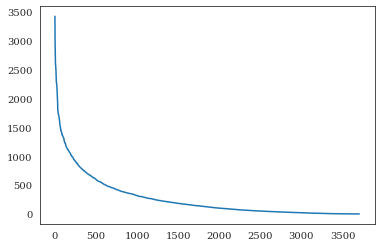

In [638]:
plt.plot(score_data.groupby(['movie_id']).count()['user_id'].sort_values(ascending=False).to_numpy())

In [701]:
a[:int(len(a)*0.20)]

user_id
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
2462     254
5488     253
846      253
1230     253
518      253
Name: movie_id, Length: 1208, dtype: int64

In [703]:
a[int(len(a)*0.80):]

user_id
5756    38
681     38
1973    38
5147    37
512     37
        ..
5725    20
3407    20
1664    20
4419    20
3021    20
Name: movie_id, Length: 1208, dtype: int64

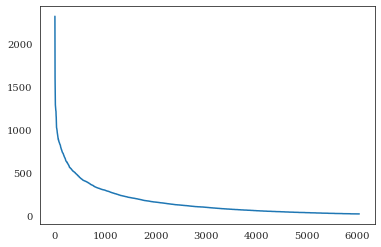

In [692]:
plt.plot(a.to_numpy())

In [877]:
def JSD(p, q):
    p = np.array(p)
    q = np.array(q)
    pq_mean = (p+q)/2
    return 0.5 * KLD(p,pq_mean) + 0.5 * KLD(q, pq_mean)
    
def KLD(p, q):
    return np.sum(p*np.log(p/q))

'''
import numpy as np
a=np.array([1,2,3])
b=np.array([2,4,6])
np.log(a/b)

print(JSD(a,b))
print(JSD(b,a))
print(KLD(a,b))
print(KLD(b,a))
'''

In [2]:
df = pd.read_csv('./ratings.dat', names=['user_id', 'movie_id', 'rating', 'timestamp'],
                        sep="::", engine='python')

# movie item lists in score data not equal to movies_extrainfos

Cold-warm transition with head \& short-tail items
1. Sort interactions by time
2. Plot transition ratio
3. Warm-cold user similarity
4. Popularity bias metrics: which to show? (item or user side?)

In [3]:
'''
freq_thres = 20
movie_cnt = df.movie_id.value_counts()
movie_freq = movie_cnt[movie_cnt>=freq_thres]
print("Total items: {}\n Freq items: {}\n Freq ratio: {:.2f}".format(len(movie_cnt), len(movie_freq), len(movie_freq)/len(movie_cnt)))

movie_freq_set = set(movie_freq.index)
score_data = df.loc[df.movie_id.apply(lambda movie: movie in movie_freq_set)]

# sanity check
assert len(set(score_data.movie_id.unique())) == len(movie_freq)
assert score_data.movie_id[0] in movie_freq_set

'''

'\nfreq_thres = 20\nmovie_cnt = df.movie_id.value_counts()\nmovie_freq = movie_cnt[movie_cnt>=freq_thres]\nprint("Total items: {}\n Freq items: {}\n Freq ratio: {:.2f}".format(len(movie_cnt), len(movie_freq), len(movie_freq)/len(movie_cnt)))\n\nmovie_freq_set = set(movie_freq.index)\nscore_data = df.loc[df.movie_id.apply(lambda movie: movie in movie_freq_set)]\n\n# sanity check\nassert len(set(score_data.movie_id.unique())) == len(movie_freq)\nassert score_data.movie_id[0] in movie_freq_set\n\n'

In [3]:
score_data = df
print("Total interactions: {}".format(len(score_data)))
print("Total users: {}".format(len(score_data.user_id.unique())))
print("Total items: {}".format(len(score_data.movie_id.unique())))

Total interactions: 1000209
Total users: 6040
Total items: 3704


In [4]:
# Sort interactions by time
score_data.sort_values(by=['timestamp'], inplace=True)

In [619]:
score_data.movie_id.value_counts()[:int(len(i_sorted)*0.2)].sum()

651347

In [5]:
# popular/tail/niche items (top/bottom 20% popularity)
i_sorted = score_data.movie_id.value_counts().index
total_items = i_sorted.values
pop_items = i_sorted[:int(len(i_sorted)*0.2)].values
tail_items = i_sorted[int(len(i_sorted)*0.2):].values
niche_items = i_sorted[int(len(i_sorted)*0.8):].values

# cold_users
n_users = len(score_data.user_id.unique())
heavy_users = score_data.user_id.value_counts().head(int(n_users*0.2)).index.values
warm_users = score_data.user_id.value_counts().head(int(n_users*0.8)).index.values
cold_users = score_data.user_id.value_counts().tail(int(n_users*0.2)).index.values

# Do users change after first k interactions?

In [7]:
score_data['pop'] = score_data['movie_id'].apply(lambda x: 1 if x in pop_items else 0)
score_data['tail'] = score_data['movie_id'].apply(lambda x: 1 if x in tail_items else 0)
score_data['niche'] = score_data['movie_id'].apply(lambda x: 1 if x in niche_items else 0)

user_pop_cnt = score_data.groupby(['user_id'])['pop']
user_tail_cnt = score_data.groupby(['user_id'])['tail']
user_niche_cnt = score_data.groupby(['user_id'])['niche']


In [8]:
_ = score_data.groupby(['user_id'])

# Head ratio of first 10 interactions
init10 = _.head(10).groupby(['user_id'])
init_head_ratio = init10['pop'].sum()/init10['pop'].count()

# Head ratio of total interactions
total_head_ratio = _['pop'].sum()/_['pop'].count()

# Head ratio of first 10 & total interactions by 100+ interaction users
heavy100 = _.filter(lambda x: len(x) >=100).groupby(['user_id'])

heavy100_init10 = heavy100.head(10).groupby(['user_id'])
init_head_ratio_heavy100 = heavy100_init10['pop'].sum()/heavy100_init10['pop'].count()

total_head_ratio_heavy100 = heavy100['pop'].sum()/heavy100['pop'].count()

print("All user initial 10 interactions: {:.4f}".format(init_head_ratio.mean()))
print("All user total interactions: {:.4f}".format(total_head_ratio.mean()))
print("Heavy user initial 10 interactions: {:.4f}".format(init_head_ratio_heavy100.mean()))
print("Heavy user total interactions: {:.4f}".format(total_head_ratio_heavy100.mean()))

All user initial 10 interactions: 0.7184
All user total interactions: 0.7138
Heavy user initial 10 interactions: 0.7128
Heavy user total interactions: 0.6789


In [9]:
#### about half of users have more than 95(≈100) interactions
u_hist_len = score_data.groupby(['user_id']).count().sort_values(['pop']).reset_index()['movie_id']
for decile in range(0, 10):
    print("{}({}%)".format(u_hist_len[int(len(u_hist_len)*decile/10)], decile*10), end=' ')

20(0%) 27(10%) 38(20%) 51(30%) 70(40%) 96(50%) 126(60%) 173(70%) 253(80%) 400(90%) 

In [10]:
import pickle
movie_dict = pickle.load(open('./m_movie_dict.pkl', 'rb'))

Divide by users' init clicks and get self-similarity (feature)

In [11]:
freq_condition = 100
freq_users = score_data.groupby(['user_id']).filter(lambda x: len(x) >=freq_condition)
fu_init = freq_users.groupby(['user_id']).head(10)
fu_later = freq_users.drop(fu_init.index)

# sanity check
assert set(fu_init.index.values).intersection(set(fu_later.index.values)) == set()

In [12]:
all_user_num = len(score_data.user_id.unique())
all_user_init_tail_num = len(score_data.groupby(['user_id']).head(10).loc[score_data.groupby(['user_id']).head(10)['pop']==False].user_id.unique())
print("Total # of users: {}".format(all_user_num))
print("No initial tail interaction by all users: {}".format(all_user_init_tail_num))
print("Ratio of users with no initial tail interaction: {:.3f}".format((all_user_num-all_user_init_tail_num)/all_user_num))

Total # of users: 6040
No initial tail interaction by all users: 5629
Ratio of users with no initial tail interaction: 0.068


In [13]:
all_user_num = len(score_data.user_id.unique())
all_user_init_tail_num = len(score_data.groupby(['user_id']).head(10).loc[score_data.groupby(['user_id']).head(10)['pop']==True].user_id.unique())
print("Total # of users: {}".format(all_user_num))
print("No initial head interaction by all users: {}".format(all_user_init_tail_num))
print("Ratio of users with no initial head interaction: {:.3f}".format((all_user_num-all_user_init_tail_num)/all_user_num))

Total # of users: 6040
No initial head interaction by all users: 6039
Ratio of users with no initial head interaction: 0.000


In [14]:
freq_user_num = len(freq_users.user_id.unique())
freq_user_init_tail_num = len(freq_users.groupby(['user_id']).head(10).loc[freq_users.groupby(['user_id']).head(10)['pop']==False].user_id.unique())
print("frequent users ({}+ interaction): {}".format(freq_condition, freq_user_num))
print("No initial tail interaction by frequent users: {}".format(freq_user_init_tail_num))
print("Ratio of users with no initial tail interaction: {:.3f}".format((freq_user_num-freq_user_init_tail_num)/freq_user_num))

frequent users (100+ interaction): 2945
No initial tail interaction by frequent users: 2759
Ratio of users with no initial tail interaction: 0.063


for interaction 100+ users,
1. similarity between first 10 clicks (1/n) and the rest clicks
2. similarity between first 10 clicks (1/n, weighted) and the rest clicks

pop item이 없는 경우에 -> 그냥 pop item interaction similarity로 대체

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def get_feature(x, movie_dict):
    return movie_dict[x[0]]

def get_pair_group_similarity(l, r, movie_dict):
    """Get group similarity between array l and array r.
    Return average similarity of array l elements.
    Caution: first column is removed for Movielens data ([:,1:])
    """
    # substitute movie id with dictionary value
    l_feature = np.apply_along_axis(get_feature, 0, l, movie_dict).squeeze(0).transpose()[:,1:] # remove ratings
    r_feature = np.apply_along_axis(get_feature, 0, r, movie_dict).squeeze(0).transpose()[:,1:] # remove ratings

    # similarity between initial/later clicks
    lr_sim = cosine_similarity(l_feature, r_feature).mean(1)
    
    return lr_sim

In [16]:
def get_headtail_similarity(user_hist, init_idx=10):
    """Get unweighted cosine similarity between head and tail items
    """
    l = user_hist.iloc[:init_idx]
    l_h = l.loc[l['pop'] == True].movie_id.to_numpy().reshape(1,-1)
    l_t = l.loc[l['pop'] == False].movie_id.to_numpy().reshape(1,-1)
    #l = l.movie_id.to_numpy().reshape(1,-1)

    r = user_hist.iloc[init_idx:]
    #r_h = r.loc[r['pop'] == True].movie_id.to_numpy().reshape(1,-1)
    r_t = r.loc[r['pop'] == False].movie_id.to_numpy().reshape(1,-1)
    r = r.movie_id.to_numpy().reshape(1,-1)

    lh_rt_sim = get_pair_group_similarity(l_h, r_t, movie_dict).mean()
    lh_r_sim = get_pair_group_similarity(l_h, r, movie_dict).mean()

    if l_t.size > 0:
        lt_rt_sim = get_pair_group_similarity(l_t, r_t, movie_dict).mean()
        lt_r_sim = get_pair_group_similarity(l_t, r, movie_dict).mean()
    else:
        lt_rt_sim, lt_r_sim = 0, 0
        
    return lh_rt_sim, lh_r_sim, l_h.size, lt_rt_sim, lt_r_sim, l_t.size

In [17]:
def get_avg_sim(init_idx, users):
    lh_rt_sims, lh_r_sims, l_h_sizes, lt_rt_sims, lt_r_sims, l_t_sizes = [], [], [], [], [], []
    
    exception_users = []
    for user_id in users.user_id.unique():
        user_hist = users[users.user_id==user_id]
        try:
            lh_rt_sim, lh_r_sim, l_h_size, lt_rt_sim, lt_r_sim, l_t_size = get_headtail_similarity(user_hist, init_idx=init_idx)
        except Exception as e:
            exception_users.append(user_id)
        if l_t_size == 0:
            continue

        lh_rt_sims.append(lh_rt_sim)
        lh_r_sims.append(lh_r_sim)
        l_h_sizes.append(l_h_size)
        lt_rt_sims.append(lt_rt_sim)
        lt_r_sims.append(lt_r_sim)
        l_t_sizes.append(l_t_size)

    print(exception_users)
    lh_rt_sims = np.array(lh_rt_sims)
    lh_r_sims = np.array(lh_r_sims)
    l_h_sizes = np.array(l_h_sizes)
    lt_rt_sims = np.array(lt_rt_sims)
    lt_r_sims = np.array(lt_r_sims)
    l_t_sizes = np.array(l_t_sizes)

    print("Cosine similarity via {} initial interactions".format(init_idx)) 
    print('init total & future total: {:.4f}'.format(((lh_r_sims+lt_r_sims)/2).mean()))
    print('init total & future tails: {:.4f}'.format(((lh_rt_sims+lt_rt_sims)/2).mean()))
    print('init heads & future total: {:.4f}'.format(lh_r_sims.mean()))
    print('init heads & future tails: {:.4f}'.format(lh_rt_sims.mean()))
    print('init tails & future total: {:.4f}'.format(lt_r_sims.mean()))
    print('init tails & future tails: {:.4f}'.format(lt_rt_sims.mean()))

In [18]:
get_avg_sim(30, freq_users)
'''
Cosine similarity via 30 initial interactions
init total & future total: 0.0933
init total & future tails: 0.0971
init heads & future total: 0.0923
init heads & future tails: 0.0935
init tails & future total: 0.0943
init tails & future tails: 0.1006
'''

KeyboardInterrupt: 

In [ ]:
get_avg_sim(20, freq_users)
'''
Cosine similarity via 20 initial interactions
init total & future total: 0.0926
init total & future tails: 0.0959
init heads & future total: 0.0914
init heads & future tails: 0.0920
init tails & future total: 0.0937
init tails & future tails: 0.0997
'''

In [ ]:
get_avg_sim(10, freq_users)
'''
Cosine similarity via 10 initial interactions
init total & future total: 0.0912
init total & future tails: 0.0937
init heads & future total: 0.0901
init heads & future tails: 0.0896
init tails & future total: 0.0923
init tails & future tails: 0.0978
'''

In [ ]:
get_avg_sim(10, score_data)

# Average similarity of warm users' interactions to a cold user's future interactions

In [19]:
def get_avg_sim_coldwarm(init_idx, users, warm_users):
    """1. Derive cosine similarity of a cold-user to warm-users (array)
    2. Based on the similarity, derive warm-users' similarity to the cold-user's future interactions
    """

    clh_wt_sims, clt_wt_sims, wt_cr_sims, wt_crt_sims = [], [], [], []
    
    exception_users = []
    for user_id in users.user_id.unique():
        user_hist = users[users.user_id==user_id]
        try:
            clh_wt_sim, clt_wt_sim, wt_cr_sim, wt_crt_sim = get_coldwarm_similarity(user_hist, freq_users, init_idx=init_idx)
        except Exception as e:
            exception_users.append(user_id)
        
        clh_wt_sims.append(clh_wt_sim)
        clt_wt_sims.append(clt_wt_sim)
        wt_cr_sims.append(wt_cr_sim)
        wt_crt_sims.append(wt_crt_sim)

    print(exception_users)
    clh_wt_sims = np.array(clh_wt_sims)
    clt_wt_sims = np.array(clt_wt_sims)
    wt_cr_sims = np.array(wt_cr_sims)
    wt_crt_sims = np.array(wt_crt_sims)
    
    '''
    print("Cosine similarity via {} initial interactions".format(init_idx)) 
    print('init total & future total: {:.4f}'.format(((lh_r_sims+lt_r_sims)/2).mean()))
    print('init total & future tails: {:.4f}'.format(((lh_rt_sims+lt_rt_sims)/2).mean()))
    print('warm heads & future total: {:.4f}'.format(lh_r_sims.mean()))
    print('init heads & future tails: {:.4f}'.format(lh_rt_sims.mean()))
    print('init tails & future total: {:.4f}'.format(lt_r_sims.mean()))
    print('init tails & future tails: {:.4f}'.format(lt_rt_sims.mean()))
    '''
    return clh_wt_sims, clt_wt_sims, wt_cr_sims, wt_crt_sims

In [20]:
def get_coldwarm_similarity(cold_hist, warm_hists, init_idx=10):
    """Get unweighted cosine similarity between cold and warm users
    """
    cl = cold_hist.iloc[:init_idx]
    cl_h = cl.loc[cl['pop'] == True].movie_id.to_numpy().reshape(1,-1)
    cl_t = cl.loc[cl['pop'] == False].movie_id.to_numpy().reshape(1,-1)
    cl = cl.movie_id.to_numpy().reshape(1,-1)
    
    if cl_t.size == 0 or cl_h.size == 0:
        raise ValueError("No initial interaction for specific type")
        
    cr = cold_hist.iloc[init_idx:]
    #r_h = r.loc[r['pop'] == True].movie_id.to_numpy().reshape(1,-1)
    cr_t = cr.loc[cr['pop'] == False].movie_id.to_numpy().reshape(1,-1)
    cr = cr.movie_id.to_numpy().reshape(1,-1)
    
    clh_wt_sims, clt_wt_sims, wt_cr_sims, wt_crt_sims = [], [], [], []
    
    for warm_user in tqdm(warm_hists.user_id.unique()):
        warm_hist = warm_hists.loc[warm_hists['user_id'] ==warm_user]
         #w_h = warm_hist.loc[warm_hist['pop'] == True].movie_id.to_numpy().reshape(1,-1)
        w_t = warm_hist.loc[warm_hist['pop'] == False].movie_id.to_numpy().reshape(1,-1)
        #w = warm_hist.movie_id.to_numpy().reshape(1,-1)
        clh_wt_sim = get_pair_group_similarity(cl_h, w_t, movie_dict).mean()
        clt_wt_sim = get_pair_group_similarity(cl_t, w_t, movie_dict).mean()
        wt_cr_sim = get_pair_group_similarity(w_t, cr, movie_dict).mean()
        wt_crt_sim = get_pair_group_similarity(w_t, cr_t, movie_dict).mean()
        #clh_w_sim = get_pair_group_similarity(cl_h, w, movie_dict).mean()
        #clt_w_sim = get_pair_group_similarity(cl_t, w, movie_dict).mean()
        
        clh_wt_sims.append(clh_wt_sim)
        clt_wt_sims.append(clt_wt_sim)
        wt_cr_sims.append(wt_cr_sim)
        wt_crt_sims.append(wt_crt_sim)
    
    return clh_wt_sims, clt_wt_sims, wt_cr_sims, wt_crt_sims

In [21]:
global_popularity = score_data.movie_id.value_counts()/len(score_data)

In [22]:
score_data['popularity'] = score_data['movie_id'].apply(lambda x: global_popularity[x])

In [23]:
global_popularity.min()

9.997910436718726e-07

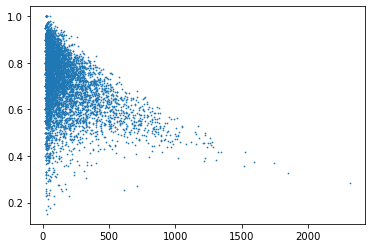

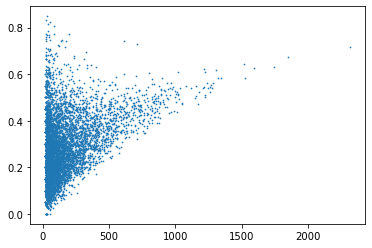

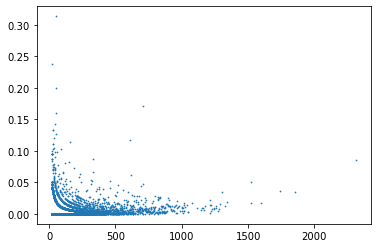

In [24]:
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_pop_cnt.sum()/user_pop_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_tail_cnt.sum()/user_tail_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_niche_cnt.sum()/user_niche_cnt.count(), s=0.5) # 비율 
plt.show()

In [58]:
score_data.groupby(['user_id'])['pop']

### Pop ratio in total data : 65%

In [70]:
len(score_data[score_data['pop']==True])/len(score_data)

0.6512108969225432

### User average pop ratio in first 10 clicks: 71.8%

In [73]:
user_pop_cnt = score_data.groupby(['user_id']).head(10).groupby(['user_id'])['pop']
(user_pop_cnt.sum()/user_pop_cnt.count()).mean()

0.7183609271523217

### User average pop ratio: 71.3%

In [74]:
user_pop_cnt = score_data.groupby(['user_id'])['pop']
(user_pop_cnt.sum()/user_pop_cnt.count()).mean()

0.7138099065864509

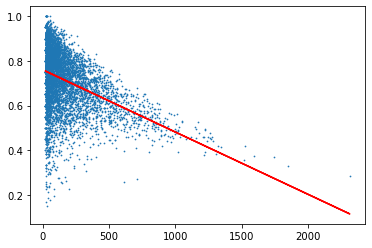

In [76]:
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_pop_cnt.sum()/user_pop_cnt.count(), s=0.5) # 비율 

x = score_data.groupby(['user_id']).movie_id.count()
y = user_pop_cnt.sum()/user_pop_cnt.count()

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b, color='red')

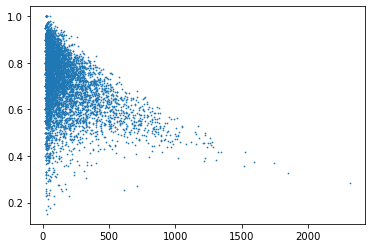

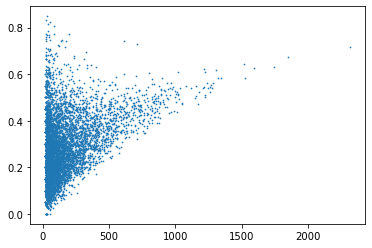

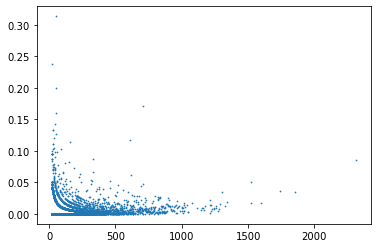

In [77]:
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_pop_cnt.sum()/user_pop_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_tail_cnt.sum()/user_tail_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_niche_cnt.sum()/user_niche_cnt.count(), s=0.5) # 비율 
plt.show()

In [78]:
global_popularity = score_data.movie_id.value_counts()/len(score_data)
global_popularity = global_popularity/global_popularity.max()
with open('global_popularity.json', 'w') as f:
    json.dump(global_popularity.to_dict(), f)

In [79]:
score_data['popularity'] = score_data['movie_id'].apply(lambda x: global_popularity[x])

In [80]:
np.random.seed(seed)
warm_user_test = np.random.choice(warm_users, int(len(warm_users)*0.25), replace=False)
warm_user_train = np.setdiff1d(warm_users, warm_user_test)

In [81]:
# new_user
cold_u_score = score_data[score_data['user_id'].apply(lambda x: True if x in cold_users else False)]
warm_u_score_train = score_data[score_data['user_id'].apply(lambda x: True if x in warm_user_train else False)]
warm_u_score_test = score_data[score_data['user_id'].apply(lambda x: True if x in warm_user_test else False)]

# no overlapping users
print(set(warm_u_score_train.index.values).intersection(set(warm_u_score_test.index.values)))
print(set(cold_u_score.index.values).intersection(set(warm_u_score_test.index.values)))
print(set(warm_u_score_train.index.values).intersection(set(cold_u_score.index.values)))

set()
set()
set()


In [82]:
print(len(warm_u_score_test.user_id.unique()))
print(len(warm_u_score_train.user_id.unique()))
print(len(cold_u_score.user_id.unique()))

1208
3624
1208


In [83]:
n_users, n_items = score_data.user_id.max()+1, score_data.movie_id.max()+1

In [42]:
import json
with open('warm_state.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['user_id']).movie_id.apply(list).to_dict(), f)
    
with open('warm_state_y.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['user_id']).rating.apply(list).to_dict(), f)

with open('warm_state_popularity.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['popularity']).rating.apply(list).to_dict(), f)
    
with open('user_old_state.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['user_id']).movie_id.apply(list).to_dict(), f)

with open('user_old_state_y.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['user_id']).rating.apply(list).to_dict(), f)
    
with open('user_old_state_popularity.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['popularity']).rating.apply(list).to_dict(), f)
    
with open('user_cold_state.json', 'w') as f:
    json.dump(cold_u_score.groupby(['user_id']).movie_id.apply(list).to_dict(), f)
    
with open('user_cold_state_y.json', 'w') as f:
    json.dump(cold_u_score.groupby(['user_id']).rating.apply(list).to_dict(), f)
    
with open('user_cold_state_popularity.json', 'w') as f:
    json.dump(cold_u_score.groupby(['popularity']).rating.apply(list).to_dict(), f)


In [37]:
global_popularity.min()

0.0002917152858809802

# Evaluation 

### Given one positive item and 99 negative items, get the performance and item recommendation ratio
### But the result differs according to the sampling

array([1208000])

In [714]:
import torch
from typing import NoReturn, List, Dict
def evaluate_method(predictions: np.ndarray, topk: list=[5, 10, 20], metrics: list=["HR", "NDCG"]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param topk: top-K values list
    :param metrics: metrics string list
    :return: a result dict, the keys are metrics@topk
    """
    evaluations = dict()
    sort_idx = (-predictions).argsort(axis=1)
    gt_rank = np.argwhere(sort_idx == 0)[:, 1] + 1
    #print(gt_rank.shape)
    for k in topk:
        hit = (gt_rank <= k)
        for metric in metrics:
            key = '{}@{}'.format(metric, k)
            if metric == 'HR':
                evaluations[key] = hit.mean().astype(np.float16)
            elif metric == 'NDCG':
                evaluations[key] = (hit / np.log2(gt_rank + 1)).mean().astype(np.float16)
            else:
                raise ValueError('Undefined evaluation metric: {}.'.format(metric))
    evaluations['n_items'] = gt_rank.shape
    return evaluations

def evaluate_method_items(predictions: torch.tensor, anchor_list:list, item_idx:torch.tensor, topk: list=[5, 10, 20], metrics: list=["HR", "NDCG"]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param anchor_list: list of item lists based on item popularity
    :param item_idx: item id list for each prediction
    """
    item_pos = item_idx.view(-1,100)[:,0].numpy()
    total_items, pop_items, tail_items, niche_items = anchor_list
    predictions = predictions.view(-1,100).numpy()
    item_idx = item_idx.numpy()
    
    pred_pop = predictions[np.isin(item_pos, pop_items)]
    pred_tail = predictions[np.isin(item_pos, tail_items)]
    pred_niche = predictions[np.isin(item_pos, niche_items)]
    
    eval_total = evaluate_method(predictions)
    eval_pop = evaluate_method(pred_pop)
    eval_tail = evaluate_method(pred_tail)
    eval_niche = evaluate_method(pred_niche)
    
    ratio_total = item_ratio(predictions, item_idx, total_items)
    ratio_pop = item_ratio(predictions, item_idx, pop_items, False)
    ratio_tail = item_ratio(predictions, item_idx, tail_items)
    ratio_niche = item_ratio(predictions, item_idx, niche_items)
    
    df = pd.DataFrame(columns={**eval_total, **ratio_total}.keys())
    df = df.append(pd.DataFrame([{**eval_total, **ratio_total}], index=['total']))
    df = df.append(pd.DataFrame([{**eval_pop, **ratio_pop}], index=['pop']))
    df = df.append(pd.DataFrame([{**eval_tail, **ratio_tail}], index=['tail']))
    df = df.append(pd.DataFrame([{**eval_niche, **ratio_niche}], index=['niche']))
    
    
    return df


def item_ratio(predictions: np.ndarray, item_idx: np.ndarray, anchor_list: np.array, plot=False, topk: list=[10, 20, 50, 100]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param anchor_list: list of item lists based on item popularity
    :param item_idx: item id list for each prediction
    """
    evaluations = dict()
    item_idx = item_idx.reshape(predictions.shape)
    sort_idx = (-predictions).argsort(axis=1)
    for k in topk:
        evaluations['top_'+str(k)] = np.isin(np.take_along_axis(item_idx,sort_idx, axis=1)[..., :k], anchor_list).mean(axis=-1).mean()
        
    for k in [10]:
        data_ratio = (user_pop_cnt.sum()/user_pop_cnt.count())[np.sort(cold_u_score.user_id.unique())]
        rec_ratio = np.isin(np.take_along_axis(item_idx,sort_idx, axis=1)[..., :k], anchor_list).reshape(1208,10, 10).mean(axis=1).mean(axis=-1)
        evaluations['UHtop_'+str(k)] = (((data_ratio - rec_ratio)**2)**(1/2)).mean()
        
        
        a = (data_ratio/(1-data_ratio))[-np.isinf((data_ratio/(1-data_ratio))+(rec_ratio/(1-rec_ratio)))]
        b = (rec_ratio/(1-rec_ratio))[-np.isinf((data_ratio/(1-data_ratio))+(rec_ratio/(1-rec_ratio)))]
        
        evaluations['odds'+str(k)] = (((a - b)**2)**(1/2)).mean()
    if plot:
        plt.hist(rec_ratio,density=True, bins=20),
        plt.hist(data_ratio,density=True, bins=20)
        plt.show()
        plt.scatter(data_ratio, rec_ratio-data_ratio, s=1)
        plt.plot([0,1], [0,0], color='red')
        plt.xlim(0,1)
        plt.ylim(-0.5, 0.5)
        plt.show()
    for k in [10]:
        _ = np.isin(np.take_along_axis(item_idx,sort_idx, axis=1)[..., :k], anchor_list)
        evaluations['Itop_'+str(k)] = _.sum()/120800
        
    return evaluations

In [551]:
(((rec_ratio[data_ratio<0.7] - data_ratio[data_ratio<0.7])**2)**(1/2)).mean()

0.2553110564096993

In [552]:
(((rec_ratio[data_ratio>0.7] - data_ratio[data_ratio>0.7])**2)**(1/2)).mean()

0.06852578067760816

In [557]:
len(data_ratio[data_ratio>0.7])

824

(array([0.03902554, 0.03902554, 0.05853832, 0.07805109, 0.09756386,
        0.21464049, 0.40976821, 0.52684484, 0.37074267, 1.05368969,
        1.03417692, 1.69761116, 1.93176443, 2.12689215, 3.10253075,
        3.00496689, 2.7903264 , 2.28299432, 1.99030274, 0.72197256]),
 array([0.15151515, 0.19393939, 0.23636364, 0.27878788, 0.32121212,
        0.36363636, 0.40606061, 0.44848485, 0.49090909, 0.53333333,
        0.57575758, 0.61818182, 0.66060606, 0.7030303 , 0.74545455,
        0.78787879, 0.83030303, 0.87272727, 0.91515152, 0.95757576,
        1.        ]),
 <BarContainer object of 20 artists>)

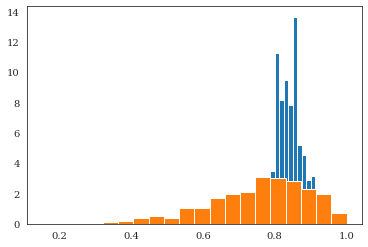

In [531]:
plt.hist(rec_ratio,density=True, bins=20),
plt.hist(data_ratio,density=True, bins=20)

In [605]:
(data_ratio/(1-data_ratio))[-np.isinf((data_ratio/(1-data_ratio))+(rec_ratio/(1-rec_ratio)))] (rec_ratio/(1-rec_ratio))[-np.isinf((data_ratio/(1-data_ratio))+(rec_ratio/(1-rec_ratio)))])

(user_id
 7       30.000000
 12       2.833333
 14      11.500000
 16       1.500000
 20      23.000000
           ...    
 6017     0.941176
 6027     8.000000
 6029     1.818182
 6034     2.500000
 6038     2.333333
 Name: pop, Length: 1197, dtype: float64,
 array([3.54545455, 3.54545455, 5.66666667, ..., 4.55555556, 2.7037037 ,
        4.88235294]))

In [ ]:
(data_ratio/(1-data_ratio))[-np.isinf((data_ratio/(1-data_ratio)))] 

In [ ]:
[12080, 10]
100, 10
10, 10, 10

In [537]:
#rank_pred = rank_pred.numpy()
#item_idx = item_idx.numpy()
evaluations = dict()
sort_idx = (-rank_pred).argsort(axis=1)
for k in topk:
    evaluations['top_'+str(k)] = np.isin(np.take_along_axis(item_idx,sort_idx, axis=1)[..., :k], pop_items).mean(axis=-1).mean()

for k in [10]:
    data_ratio = (user_pop_cnt.sum()/user_pop_cnt.count())[np.sort(cold_u_score.user_id.unique())]
    rec_ratio = np.isin(np.take_along_axis(item_idx,sort_idx, axis=1)[..., :k], pop_items).reshape(1208,10, 10).mean(axis=1).mean(axis=-1)
    evaluations['UHtop_'+str(k)] = (((data_ratio - rec_ratio)**2)**(1/2)).mean()
    evaluations['UTtop_'+str(k)] = ((((1-data_ratio) - rec_ratio)**2)**(1/2)).mean()

In [539]:
evaluations

{'top_1480': 0.2006680463576159,
 'UHtop_10': 0.12637005222974182,
 'UTtop_10': 0.5859406812913286}

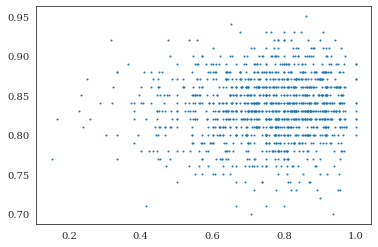

In [543]:
plt.scatter(data_ratio, rec_ratio, s=1)
#plt.ylim(0,1)
#plt.xlim(0,1)
plt.show()

(array([0.03902554, 0.03902554, 0.05853832, 0.07805109, 0.09756386,
        0.21464049, 0.40976821, 0.52684484, 0.37074267, 1.05368969,
        1.03417692, 1.69761116, 1.93176443, 2.12689215, 3.10253075,
        3.00496689, 2.7903264 , 2.28299432, 1.99030274, 0.72197256]),
 array([0.15151515, 0.19393939, 0.23636364, 0.27878788, 0.32121212,
        0.36363636, 0.40606061, 0.44848485, 0.49090909, 0.53333333,
        0.57575758, 0.61818182, 0.66060606, 0.7030303 , 0.74545455,
        0.78787879, 0.83030303, 0.87272727, 0.91515152, 0.95757576,
        1.        ]),
 <BarContainer object of 20 artists>)

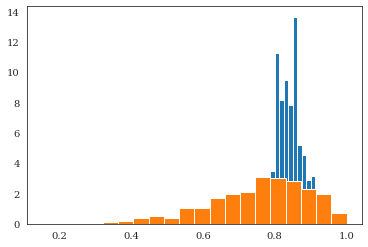

In [531]:
plt.hist(rec_ratio,density=True, bins=20),
plt.hist(data_ratio,density=True, bins=20)

In [526]:
data_ratio[data_ratio>0.7]

user_id
4       1.000000
7       0.967742
12      0.739130
14      0.920000
20      0.958333
          ...   
5993    0.933333
5999    0.703704
6008    0.914286
6027    0.888889
6034    0.714286
Name: pop, Length: 824, dtype: float64

In [524]:
data_ratio, rec_ratio, (data_ratio - rec_ratio), (data_ratio - rec_ratio)**2, ((data_ratio - rec_ratio)**2)**(1/2), (((data_ratio - rec_ratio)**2)**(1/2)).mean()

(user_id
 4       1.000000
 7       0.967742
 12      0.739130
 14      0.920000
 16      0.600000
           ...   
 6017    0.484848
 6027    0.888889
 6029    0.645161
 6034    0.714286
 6038    0.700000
 Name: pop, Length: 1208, dtype: float64,
 array([0.84, 0.78, 0.78, ..., 0.82, 0.73, 0.83]),
 user_id
 4       0.160000
 7       0.187742
 12     -0.040870
 14      0.070000
 16     -0.280000
           ...   
 6017   -0.325152
 6027    0.128889
 6029   -0.174839
 6034   -0.015714
 6038   -0.130000
 Name: pop, Length: 1208, dtype: float64,
 user_id
 4       0.025600
 7       0.035247
 12      0.001670
 14      0.004900
 16      0.078400
           ...   
 6017    0.105724
 6027    0.016612
 6029    0.030569
 6034    0.000247
 6038    0.016900
 Name: pop, Length: 1208, dtype: float64,
 user_id
 4       0.160000
 7       0.187742
 12      0.040870
 14      0.070000
 16      0.280000
           ...   
 6017    0.325152
 6027    0.128889
 6029    0.174839
 6034    0.015714
 6038    0.13

In [608]:
test_ways = ['new_user']#, 'old_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['', 'PD', 'IPS', 'ColA', 'ColMSU32'] # , 
total_df = pd.DataFrame([])
seeds = [0]
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, str(seed_tmp), '.pt']))
            if test_way == 'new_user':
                rank_pred = predictions[[c_pos_neg_u, c_pos_neg_i_]].reshape(12080, 100)
                item_idx = c_pos_neg_i
            else:
                rank_pred = predictions[[w_pos_neg_u, w_pos_neg_i_]].reshape(12080, 100)
                item_idx = w_pos_neg_i
                
            tmp_df = evaluate_method_items(rank_pred, anchor_list=anchor_list, item_idx=item_idx)
            tmp_df['seed'] = seed_tmp
            tmp_df['model'] = model
            tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
            tmp_df['test_way'] = test_way[:-5]
            tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
            tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
            total_df = total_df.append(tmp_df.set_index('index'))
    #     break
    # break

In [136]:
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        predictions = torch.load('_'.join(['../../eval_result/', 'preds', test_way, str(seed_tmp), '.pt']))
        item_idx = torch.load('_'.join(['../../eval_result/', 'item_idx', test_way, str(seed_tmp), '.pt']))
        tmp_df = evaluate_method_items(predictions, anchor_list=anchor_list, item_idx=item_idx)
        tmp_df['seed'] = seed_tmp
        tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
        tmp_df['test_way'] = test_way[:-5]
        tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
        tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
        total_df = total_df.append(tmp_df.set_index('index'))

../../eval_result/_preds_10_old_user_1_.pt
../../eval_result/_preds_20_old_user_1_.pt
../../eval_result/_preds_old_user_1_.pt
../../eval_result/_preds_10_old_user_2_.pt
../../eval_result/_preds_20_old_user_2_.pt
../../eval_result/_preds_old_user_2_.pt
../../eval_result/_preds_10_old_user_3_.pt
../../eval_result/_preds_20_old_user_3_.pt
../../eval_result/_preds_old_user_3_.pt
../../eval_result/_preds_10_old_user_4_.pt
../../eval_result/_preds_20_old_user_4_.pt
../../eval_result/_preds_old_user_4_.pt
../../eval_result/_preds_10_old_user_5_.pt
../../eval_result/_preds_20_old_user_5_.pt
../../eval_result/_preds_old_user_5_.pt


In [87]:
df_mean = total_df.groupby(['test_way', 'type']).mean().drop(['seed'], axis=1)


# Correlation between history size and popularity bias 
### (for 1 positive and 99 randomly sampled negative items, may not show proper trends because not all the popular items are included)

In [210]:
old_user = warm_u_score_test.groupby(['user_id']).movie_id.apply(list)
old_user_hist_len = warm_u_score_test.groupby(['user_id']).movie_id.count()

new_user = cold_u_score.groupby(['user_id']).movie_id.apply(list)
new_user_hist_len = cold_u_score.groupby(['user_id']).movie_id.count()

In [90]:
old_user_hist_len.values

array([ 51, 401, 108, ..., 147, 271, 123])

In [186]:
def plot_ratio(old_user_hist_len, pop_ratio, k):
    plt.scatter(old_user_hist_len, pop_ratio, s=5)
    plt.xlabel("history length")
    plt.ylabel("pop item recommendation ratio")
    #plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
    
    plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
    #plt.show()
    
    
def plot_ratio_ax(old_user_hist_len, pop_ratio, k, ax):
    ax.scatter(old_user_hist_len, pop_ratio, s=5)
    ax.set_xlabel("history length")
    ax.set_ylabel("pop item recommendation ratio")
    ax.set_title("in top-{}".format(str(k)))

In [187]:
item_idx.numpy().shape, sort_idx.numpy().shape

((1208, 10, 100), (1208, 10, 100))

In [188]:
pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)

In [189]:
w_preds = torch.load('_'.join(['../../eval_result/', 'preds', 'old_user', str(1), '.pt']))
c_preds = torch.load('_'.join(['../../eval_result/', 'preds', 'new_user', str(1), '.pt']))
w_idx = torch.load('_'.join(['../../eval_result/', 'item_idx', 'old_user', str(1), '.pt']))
c_idx = torch.load('_'.join(['../../eval_result/', 'item_idx', 'new_user', str(1), '.pt']))

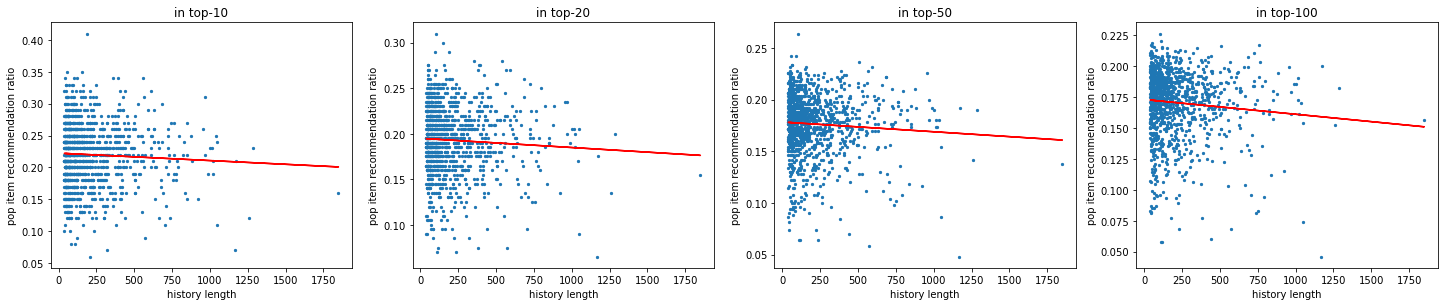

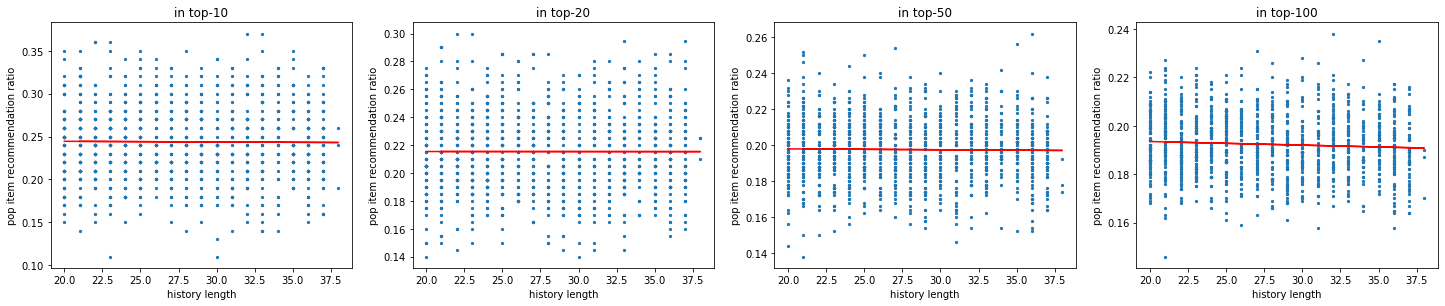

In [212]:
evaluations = dict()
item_idx = w_idx.reshape(w_preds.shape)
sort_idx = (-w_preds).argsort(axis=1)
topks = [10, 20, 50, 100]
fig, axs = plt.subplots(1, len(topks), figsize=(20,4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
for idx, k in enumerate(topks):    
    pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)
    x = old_user_hist_len
    y = pop_ratio
    m, b = np.polyfit(x, y, 1)
    axs[idx].plot(x, m*x + b, color='red')
    
    ax = plot_ratio_ax(x, y, k, axs[idx])
    evaluations['top_'+str(k)] = pop_ratio

plt.show()

item_idx = c_idx.reshape(c_preds.shape)
sort_idx = (-c_preds).argsort(axis=1)
fig, axs = plt.subplots(1, len(topks), figsize=(20,4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
for idx, k in enumerate(topks):    
    pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(new_user_hist_len), -1).mean(axis=-1)
    x = new_user_hist_len
    y = pop_ratio
    m, b = np.polyfit(x, y, 1)
    axs[idx].plot(x, m*x + b, color='red')
    
    ax = plot_ratio_ax(x, y, k, axs[idx])
    evaluations['top_'+str(k)] = pop_ratio

plt.show()


In [191]:
pop_ratio =  np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)

[0.26 0.29 0.26 ... 0.17 0.16 0.21]
[0.22  0.2   0.225 ... 0.18  0.14  0.18 ]
[0.184 0.154 0.19  ... 0.184 0.158 0.178]
[0.174 0.149 0.177 ... 0.19  0.153 0.179]


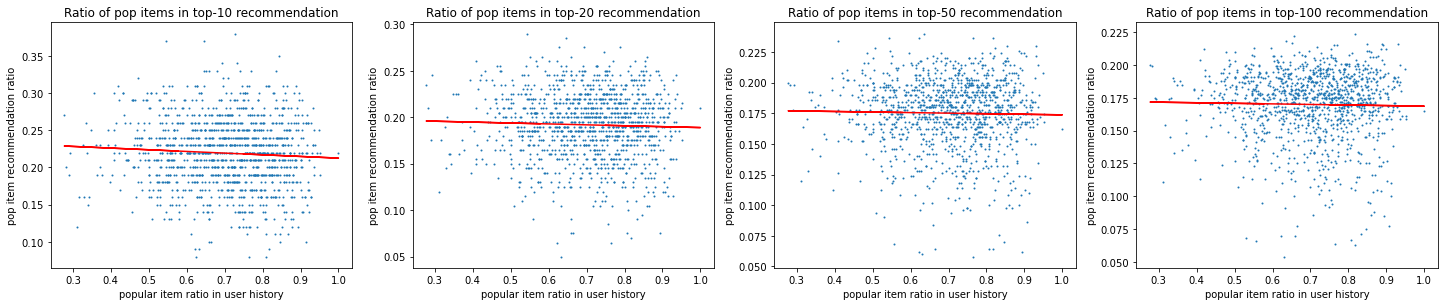

In [209]:
evaluations = dict()
item_idx = item_idx.reshape(predictions.shape)
sort_idx = (-predictions).argsort(axis=1)

topks = [10, 20, 50, 100]
fig, axs = plt.subplots(1, len(topks), figsize=(20,4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.2)
for idx, k in enumerate(topks):    
    pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)
    #ax = plot_ratio(old_user_hist_len, pop_ratio, k)
    evaluations['top_'+str(k)] = pop_ratio
    x, y = (user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio
    m, b = np.polyfit(x, y, 1)
    axs[idx].plot(x, m*x + b, color='red')    
    axs[idx].scatter(x, y, s=1)
    axs[idx].set_xlabel("popular item ratio in user history")
    axs[idx].set_ylabel("pop item recommendation ratio")
    axs[idx].set_title("Ratio of pop items in top-{} recommendation".format(str(k)))
plt.show()

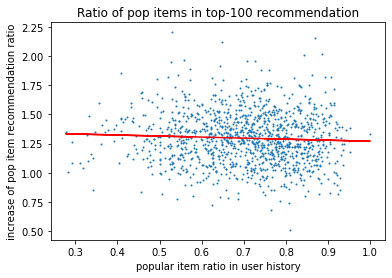

In [203]:
x, y =(user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], evaluations['top_10']/evaluations['top_100']
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y, s=1)
plt.plot(x, m*x + b, color='red')
plt.xlabel("popular item ratio in user history")
plt.ylabel("increase of pop item recommendation ratio")
plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
plt.show()

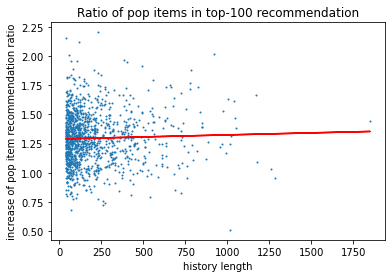

In [205]:
x,y = old_user_hist_len, evaluations['top_10']/evaluations['top_100']
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y, s=1)
plt.plot(x, m*x + b, color='red')
plt.xlabel("history length")
plt.ylabel("increase of pop item recommendation ratio")
plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
plt.show()

In [214]:
import copy
def get_mask_index(data_df):
    '''Get user-item interaction index pair.'''
    tmp_df = copy.deepcopy(data_df[['user_id', 'movie_id']])
    uids = sorted(tmp_df['user_id'].unique())
    user2id = dict(zip(uids, range(len(uids))))
    tmp_df['user_id'] = tmp_df['user_id'].apply(lambda x: user2id[x])
    ui_pairs = tmp_df[['user_id', 'movie_id']].values
    return ui_pairs

def convert_item_to_index(ui_pairs, item_idx):
    ''' Convert item index to given array index
    item_idx has values up to 3952, but index is up to 3704 because there are a few missing movies
    If user u interacted k-th item whose array index is n, then we change from (u,k) to (u,n)
    '''
    
    # assert (item_idx == item_idx[0]).all().item() # Check all the item indices are the same!
    item2id = dict(zip(item_idx[0].numpy(), range(len(item_idx[0])))) 

    # sanity check
    sanity_item = ui_pairs[0][1] # if user used item 1357
    # get the item's index in prediction via item2id
    assert sanity_item == item_idx[:, item2id[sanity_item]][0] # access the value obtained from item's index
    
    ui_pairs[:, 1] = np.array([item2id[item] for item in ui_pairs[:, 1]])
    return ui_pairs

In [415]:
len(item_idx[0])

100

In [215]:
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        predictions = torch.load('_'.join(['../../eval_result/', 'preds', test_way, str(seed_tmp), '.pt']))
        item_idx = torch.load('_'.join(['../../eval_result/', 'item_idx', test_way, str(seed_tmp), '.pt']))
        tmp_df = evaluate_method_items(predictions, anchor_list=anchor_list, item_idx=item_idx)
        tmp_df['seed'] = seed_tmp
        tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
        tmp_df['test_way'] = test_way[:-5]
        tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
        tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
        total_df = total_df.append(tmp_df.set_index('index'))

# recommendation of popular items (of all items)

In [217]:
ui_pairs = get_mask_index(warm_u_score_test)

In [218]:
#ui_pairs = get_mask_index(warm_u_score_test)

# sups: support item set saved during 
# all interacted items excluding last 10 in warm_u_score_test.groupby(['user_id']).movie_id.apply(list).to_dict()
sups = torch.load('_'.join(['../../eval_result/', 'total_sup', 'old_user', str(seed_tmp), '.pt']))

ui_pairs = []
for u_idx, u_sup in enumerate(sups):
    for sup in u_sup:
        ui_pairs.append([u_idx, sup])

ui_pairs = np.array(ui_pairs)
#ui_pairs = convert_item_to_index(ui_pairs, item_idx)
# ui_pair[u, i]: row index of a user u in 1208 rows tensor, column index of a user i in 3704 columns tensor

In [220]:
test_ways = ['old_user']# ['10_old_user', '20_old_user', 'old_user']#,'new_user']
seeds = [1]
masking = True
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df_all = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        #predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way, str(seed_tmp), '.pt']))
        #item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way, str(seed_tmp), '.pt']))
        evaluations = dict()
        #break
        # 이용기록을 masking을 하는 경우, 해당 인덱스를 -inf값으로 집어넣어준다. 값이 낮아야 -1을 곱한 후 오름차순 소팅하면 랭킹이 뒤로밀림. 
        if masking:
            predictions[ui_pairs.transpose()] = float('-inf')
        
        
        # [user, item] prediction 결과를 sorting하고
        # sorting된 결과에서 pop_item의 비율을 재서 plot을 해봄.
        #topk = [10, 20, 50, 100, 500]
        #topk = [int(0.25*len(pop_items)), int(0.5*len(pop_items)), len(pop_items)]
        topk = [int(0.5*len(pop_items))]
        
        sort_idx = (-predictions).argsort(axis=1)
        item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
            evaluations['top_'+str(k)] = pop_ratio
        
            plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio, s=1)
            plt.xlabel("popular item ratio in user history")
            plt.ylabel("pop item recommendation ratio")
            plt.title("Ratio of pop items in top-{}% recommendation".format(round(100*k/total_items.__len__())))
            plt.show()
            
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions    
            plot_ratio(old_user_hist_len, pop_ratio, k)
        break
    break

IndexError: index 1476 is out of bounds for dimension 1 with size 10

In [227]:
(user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()>100).any(axis=1).values].mean()

0.699314047255752

In [233]:
(user_pop_cnt.sum()/user_pop_cnt.count())[cold_u_score.user_id.unique()].mean()

0.7521214458909674

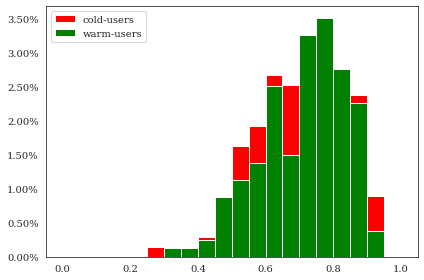

In [657]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], color='red' , bins=20, density=True, range=(0,1), label='cold-users')
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()> 400).any(axis=1).values], color='green', bins=20, density=True, range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

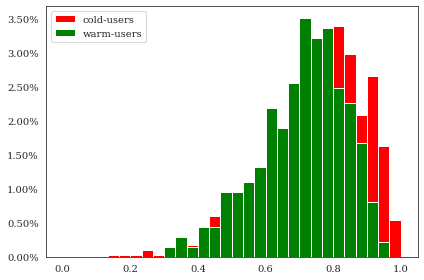

In [361]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[cold_u_score.user_id.unique()], color='red', bins=30, density=True, range=(0,1), label='cold-users')
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()[(warm_u_score_test.groupby(['user_id']).count()> 200).any(axis=1).values]], color='green', bins=30, density=True, range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

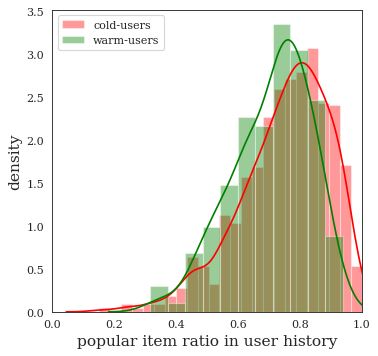

In [667]:
import seaborn as sns
sns.set_style("white")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.figure(figsize=(5,5), dpi= 80)
sns.distplot((user_pop_cnt.sum()/user_pop_cnt.count())[cold_u_score.user_id.unique()], color="red", label='cold-users')
sns.distplot((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()[(warm_u_score_test.groupby(['user_id']).count()> 380).any(axis=1).values]], color='green', label='warm-users')
plt.xlim(0,1)
plt.xlabel("popular item ratio in user history", size=14)
plt.ylabel("density", size=14)
plt.legend()

old_user
new_user


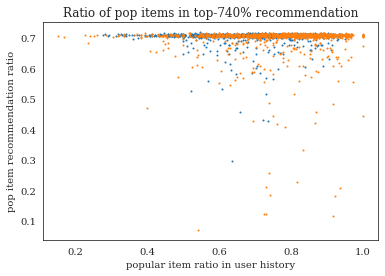

In [364]:
test_ways = ['old_user', 'new_user']# ['10_old_user', '20_old_user', 'old_user']#,'new_user']
seeds = [1]
masking = True
plot_ratios = []
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df_all = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        print(test_way)
        predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way, str(seed_tmp), '.pt']))
        item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way, str(seed_tmp), '.pt']))
        evaluations = dict()
        topk = [int(1*len(pop_items))]#, int(len(pop_items))]
        
        sort_idx = (-predictions).argsort(axis=1)
        item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
            evaluations['top_'+str(k)] = pop_ratio
        
            if test_way == 'old_user':
                hist_ratio = warm_u_score_test
            else:
                hist_ratio = cold_u_score
                
            plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[hist_ratio.user_id.unique()], pop_ratio, s=1)
            plt.xlabel("popular item ratio in user history")
            plt.ylabel("pop item recommendation ratio")
            plt.title("Ratio of pop items in top-{}% recommendation".format(str(k)))
            
            #plot_ratio(old_user_hist_len, pop_ratio, k)
        plot_ratios.append(pop_ratio)
        
    plt.show()

In [ ]:
sns.distplot(plot_ratios[0]warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1), color='green', label='warm-users')


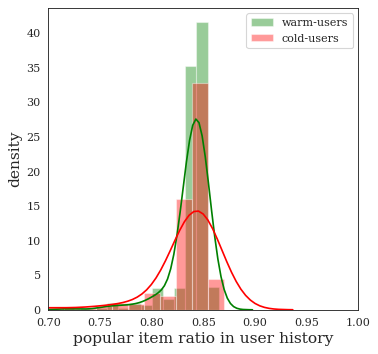

In [352]:
import seaborn as sns
sns.set_style("white")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.figure(figsize=(5,5), dpi= 80)
sns.distplot(plot_ratios[0][(warm_u_score_test.groupby(['user_id']).count()>100).any(axis=1).values], color='green', label='warm-users')
sns.distplot(plot_ratios[1], color='red', label='cold-users')
plt.xlim(0.7,1)
plt.xlabel("popular item ratio in user history", size=14)
plt.ylabel("density", size=14)
plt.legend()

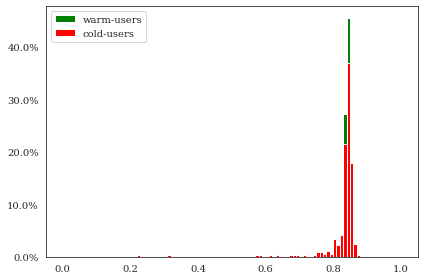

In [350]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(plot_ratios[0][(warm_u_score_test.groupby(['user_id']).count()>100).any(axis=1).values], bins=100, density=True, color='green', range=(0,1), label='warm-users')
ax.hist(plot_ratios[1], bins=100, density=True, color='red', range=(0,1), label='cold-users')

#ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], bins=20, density=True, color='red', range=(0,1), label='cold-users')
#ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()> 100).any(axis=1).values], bins=20, density=True, color='green', range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

In [687]:
a = score_data.groupby(['user_id']).count()['movie_id'].sort_values(ascending=False)
a

user_id
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Name: movie_id, Length: 6040, dtype: int64

<AxesSubplot:xlabel='user_id'>

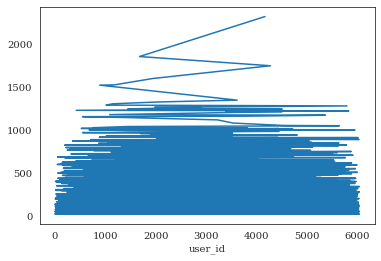

In [689]:
a.plot()

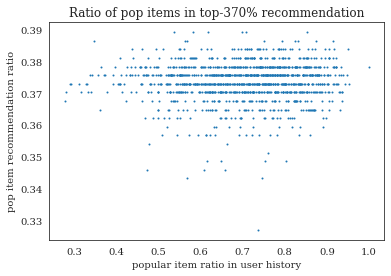

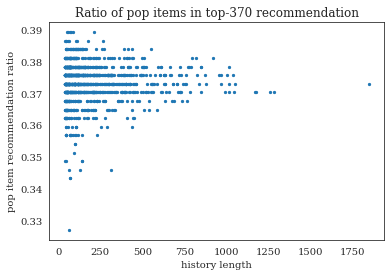

In [309]:
test_ways = ['old_user']# ['10_old_user', '20_old_user', 'old_user']#,'new_user']
seeds = [1]
masking = True
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df_all = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+'PD', str(seed_tmp), '.pt']))
        item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way+'PD', str(seed_tmp), '.pt']))
        evaluations = dict()
        #break
        # 이용기록을 masking을 하는 경우, 해당 인덱스를 -inf값으로 집어넣어준다. 값이 낮아야 -1을 곱한 후 오름차순 소팅하면 랭킹이 뒤로밀림. 
        #if masking:
        #    predictions[ui_pairs.transpose()] = float('-inf')
        
        
        # [user, item] prediction 결과를 sorting하고
        # sorting된 결과에서 pop_item의 비율을 재서 plot을 해봄.
        #topk = [10, 20, 50, 100, 500]
        #topk = [int(0.25*len(pop_items)), int(0.5*len(pop_items)), len(pop_items)]
        topk = [int(0.5*len(pop_items))]
        
        sort_idx = (-predictions).argsort(axis=1)
        item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
            evaluations['top_'+str(k)] = pop_ratio
        
            plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio, s=1)
            plt.xlabel("popular item ratio in user history")
            plt.ylabel("pop item recommendation ratio")
            plt.title("Ratio of pop items in top-{}% recommendation".format(str(k)))
            plt.show()
            
        for k in topk:
            pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions    
            plot_ratio(old_user_hist_len, pop_ratio, k)
        break
    break

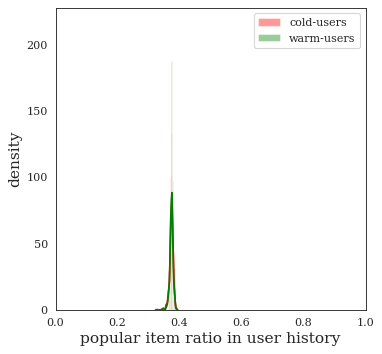

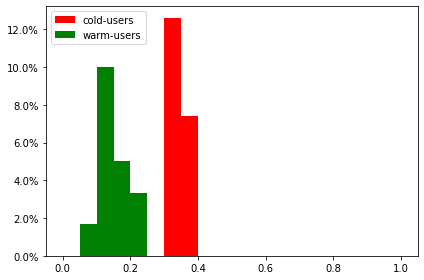

In [639]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], bins=20, density=True, color='red', range=(0,1), label='cold-users')
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()> 1000).any(axis=1).values], bins=20, density=True, color='green', range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

# PDA

In [144]:
global_popularity.min()

2858    1.000000
260     0.872520
1196    0.872229
1210    0.841015
480     0.779463
          ...   
989     0.000292
3890    0.000292
3290    0.000292
642     0.000292
2226    0.000292
Name: movie_id, Length: 3704, dtype: float64

In [ ]:
topk = [int(0.5*len(pop_items))]

predictions_ = predictions*(torch.tensor(global_popularity[item_idx[0].numpy()].values)**0.1)
sort_idx = (-predictions_).argsort(axis=1)
item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
for k in topk:
    pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
    evaluations['top_'+str(k)] = pop_ratio

    plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], pop_ratio, s=1)
    plt.xlabel("popular item ratio in user history")
    plt.ylabel("pop item recommendation ratio")
    plt.title("Ratio of pop items in top-{}% recommendation".format(str(k)))
    plt.show()

for k in topk:
    pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions    
    plot_ratio(old_user_hist_len, pop_ratio, k)

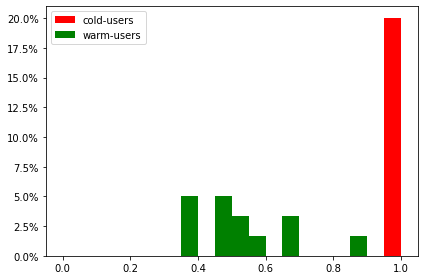

In [663]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], bins=20, density=True, color='red', range=(0,1), label='cold-users')
ax.hist(pop_ratio[(warm_u_score_test.groupby(['user_id']).count()> 1000).any(axis=1).values], bins=20, density=True, color='green', range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

In [641]:
a = np.array([[10, 30, 20], 
              [60, 40, 50]])
np.sort(a, axis=1) # array([[10, 20, 30],
                   #        [40, 50, 60]])
ai = np.argsort(a, axis=1); ai # array([[0, 2, 1],
                               #        [1, 2, 0]])
    
np.take_along_axis(a, ai, axis=1) # array([[10, 20, 30],
                                  #        [40, 50, 60]])

array([[10, 20, 30],
       [40, 50, 60]])

# Genre-wise comparison

$P(v, S'|u) = \sum_{d\in{\Gamma,\Gamma'}}P(d|u)P(v|d)\Pi_{i\in S}(1-P(i|d,S))$: score that a user u will like the item in S'

$P(v|d)$: 1 if $v\in d$ and $0$ otherwise -> let's only calculate items in 

$P(i|d,S)$: 1 if $i \in S$ covers $d$ already and 0 otherwise (Binary)

$P(d|u)$: likelihood by the ratio of the user's interacted items in category $d$

$\Pi_{i\in S}(1-P(i|d,S))$ in Binary xQuAD is 1 only if current items in S have not covered the category d yet.

0. Get recommendation list of top 100 score items

while tail item not in the top 10 list: 

    1. normalize scores to be likelihood (acc score)
    2. get each user's tail item ratio and add to each tail item in the top 100 list (acc + reg)

### Given prediction for total items
1. sample one pos, 99 neg among total items (done)
2. total items -> top 10% item recommendation ratio
3. 100 items -> performance, popularity metric (top 5, top 50)
4. correlation between item popularity and score - score as the avg. of predictions
5. how the prediction changed after update?
6. scatter plot each user (cold as triangle and warm as circle, with color bars in it)

# Prediction accuracy of fair models

In [376]:
user_clicked_set = pickle.load(open("user_clicked_set.pkl", 'rb'))

In [377]:
unique_itemset = set(score_data.movie_id.unique())

from random import randint
import random
def sample_neg_items(u_id, user_clicked_set, num_neg=99):
    r"""Sample positive (for meta_batch) and negative items (for meta and current batch).
    For training: randomly sample 1 item.
    For testing: randomly sample 99 item.
    """
    neg_items = torch.empty(num_neg, dtype=torch.int64)
    user_clicked_set = user_clicked_set[u_id]
    for neg in range(num_neg):
        neg_item = _randint_w_exclude(user_clicked_set)
        neg_items[neg] = neg_item

    return neg_items

def _randint_w_exclude(clicked_set):
    randItem = randint(1, n_items)
    return _randint_w_exclude(clicked_set) if (randItem in clicked_set) or (randItem not in unique_itemset) else randItem

def get_pos_neg_pair(test):
    random.seed(seed)
    torch.manual_seed(seed)
    #warm_u_score_test.groupby(['user_id']).tail(10).sort_values(by=['user_id', 'timestamp'])
    test_users = np.sort(test.user_id.unique())

    test_ui = test.groupby(['user_id']).tail(10).sort_values(by=['user_id', 'timestamp'])[['user_id', 'movie_id']].to_numpy()
    pos_neg_i = torch.empty([test_ui.shape[0], 100], dtype=torch.int64)
    pos_neg_i[:,0] = torch.tensor(test_ui[:,1])
    for idx, u_id in tqdm(enumerate(test_ui[:,0])):
        pos_neg_i[idx, 1:100] = sample_neg_items(int(u_id), user_clicked_set)

    # convert user and item index into array index
    user2id = dict(zip(test_users, range(len(test_users))))
    item2id = dict(zip(item_idx[0].numpy(), range(len(item_idx[0]))))

    pos_neg_u = torch.arange(1208, dtype=torch.int64).expand(1000,1208).transpose(1,0).reshape(-1).numpy()
    pos_neg_i_ = copy.deepcopy(pos_neg_i).apply_(lambda x: item2id[int(x)]).reshape(-1).numpy()

    #rank_pred = predictions[[pos_neg_u, pos_neg_i_]].reshape(12080, 100)

    return pos_neg_u, pos_neg_i, pos_neg_i_

In [378]:
w_pos_neg_u, w_pos_neg_i, w_pos_neg_i_ = get_pos_neg_pair(warm_u_score_test)
c_pos_neg_u, c_pos_neg_i, c_pos_neg_i_ = get_pos_neg_pair(cold_u_score)

12080it [00:24, 500.13it/s]
12080it [00:06, 1910.74it/s]


In [624]:
import warnings
warnings.filterwarnings('ignore')

In [1002]:
len(score_data.loc[score_data['pop']==1])/len(score_data)

0.6512108969225432

In [423]:
evaluate_method_items

<function __main__.evaluate_method_items(predictions: <built-in method tensor of type object at 0x7ff8d70cfca0>, anchor_list: list, item_idx: <built-in method tensor of type object at 0x7ff8d70cfca0>, topk: list = [5, 10, 20], metrics: list = ['HR', 'NDCG']) -> Dict[str, float]>

In [715]:
test_ways = ['new_user']#, 'old_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['', 'PD', 'IPS', 'ColA', 'ColMSU32'] # , 
total_df = pd.DataFrame([])
seeds = [0]
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, str(seed_tmp), '.pt']))
            if test_way == 'new_user':
                rank_pred = predictions[[c_pos_neg_u, c_pos_neg_i_]].reshape(12080, 100)
                item_idx = c_pos_neg_i
            else:
                rank_pred = predictions[[w_pos_neg_u, w_pos_neg_i_]].reshape(12080, 100)
                item_idx = w_pos_neg_i
                
            tmp_df = evaluate_method_items(rank_pred, anchor_list=anchor_list, item_idx=item_idx)
            tmp_df['seed'] = seed_tmp
            tmp_df['model'] = model
            tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
            tmp_df['test_way'] = test_way[:-5]
            tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
            tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
            total_df = total_df.append(tmp_df.set_index('index'))
            

In [717]:
0.833 - 0.651

0.18199999999999994

In [716]:
total_df[total_df['test_way'] == 'new']

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,UHtop_10,odds10,Itop_10,seed,model,type,test_way,type_
index,,,,,,,,,,,,,,,,,,,
new_user_0_total,0.331787,0.218628,0.487305,0.268555,0.683105,0.317871,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,,total,new,new_total
new_user_0_pop,0.428467,0.284424,0.617188,0.345215,0.829102,0.398926,"(9098,)",0.833667,0.69195,0.392078,0.200668,0.12637,3.772586,0.833667,0,,pop,new,new_pop
new_user_0_tail,0.03656,0.017685,0.091553,0.035034,0.237793,0.071289,"(2982,)",0.166333,0.30805,0.607922,0.799332,0.585941,4.944667,0.166333,0,,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.0,0.0,"(55,)",0.0,0.000124,0.018164,0.199508,0.752121,5.146885,0.0,0,,niche,new,new_niche
new_user_0_total,0.152466,0.090942,0.268311,0.128052,0.431396,0.169067,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,PD,total,new,new_total
new_user_0_pop,0.168823,0.09845,0.298096,0.139893,0.471924,0.183594,"(9098,)",0.433121,0.39137,0.309593,0.200668,0.324861,4.385943,0.433121,0,PD,pop,new,new_pop
new_user_0_tail,0.1026,0.068176,0.177002,0.091919,0.307617,0.124451,"(2982,)",0.566879,0.60863,0.690407,0.799332,0.210538,3.916303,0.566879,0,PD,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.018188,0.004139,"(55,)",0.023526,0.032173,0.070478,0.199508,0.728595,5.122549,0.023526,0,PD,niche,new,new_niche
new_user_0_total,0.245239,0.1521,0.400635,0.202026,0.60498,0.253418,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,IPS,total,new,new_total


In [383]:
def fairReg_binary(rec_list, index_list, pop_set, lambd = 0, topk=10):
    """
    0. Get recommendation list of top 100 score items of a user
    while tail item not in the top 10 list:
    1. normalize scores to be likelihood (acc score)
    2. get each user's tail item ratio and add to each tail item in the top 100 list (acc + reg)
    
    Warning: if inf value is in rec_list, results in normalization error
    
    Input:
        rec_list: model score for recommended items
        index_list: index of recommended items
    """
    pos_index = 0
    #assert rec_list.shape[-1] == 100
    # Normalization to make the scores between 0~1
    rec_list = (rec_list - rec_list.min())/(rec_list.max()-rec_list.min())
    assert rec_list.max() == 1 and rec_list.min() == 0
    
    # bulk version:
    # given recommendation list, add bonus fair score to all tail items
    # until at least a tail item is included in top-k 
    #while lambd != 0:
    
    # sort rec_list item index
    rec_list, rank_index = torch.sort(rec_list, descending=True)
    index_list = index_list[rank_index]
    pos_index = int((pos_index == rank_index).nonzero(as_tuple=True)[0])

    if is_fair(index_list[:topk], pop_set):
        return rec_list, index_list, pos_index
    #    break

    # add lambd score to tail items in the rec_list
    for idx, item in enumerate(index_list):
        if int(item) not in pop_set:
            rec_list[idx] += lambd

        
    return rec_list, index_list, pos_index

def is_fair(index_list, pop_set):
    for item in index_list:
        if int(item) not in pop_set:
            return True
    return False

### Fair df: regularizer (adding fair score lambda to the model)

In [613]:
lambds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
test_ways = ['new_user', 'old_user']
fair_df = pd.DataFrame([])
pop_set = set(pop_items)
for seed_tmp in seeds:
    for test_way in test_ways:
        predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way, str(seed_tmp), '.pt']))
        if test_way == 'new_user':
            rank_pred = predictions[[c_pos_neg_u, c_pos_neg_i_]].reshape(12080, 100)
            item_idx = c_pos_neg_i
        else:
            rank_pred = predictions[[w_pos_neg_u, w_pos_neg_i_]].reshape(12080, 100)
            item_idx = w_pos_neg_i

        for lambd in tqdm(lambds):
            
            fair_preds = torch.empty([12080, 100], dtype=torch.float64)
            fair_item_idx = torch.empty([12080, 100], dtype=torch.int64)
            
            for row in range(12080):
                rec_list, index_list, pos_index = fairReg_binary(rank_pred[row], item_idx[row], pop_set, lambd = lambd, topk=10)
                rec_list[0], rec_list[pos_index] = rec_list[pos_index].item(), rec_list[0].item()
                index_list[0], index_list[pos_index] = index_list[pos_index].item(), index_list[0].item()
                fair_preds[row] = rec_list
                fair_item_idx[row] = index_list    
                
            tmp_df = evaluate_method_items(fair_preds, anchor_list=anchor_list, item_idx=fair_item_idx)
            tmp_df['seed'] = seed_tmp
            tmp_df['model'] = 'FR'
            tmp_df['lambd'] = lambd
            tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
            tmp_df['test_way'] = test_way[:-5]
            tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
            tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
            fair_df = fair_df.append(tmp_df.set_index('index'))


100%|████████████████████████████████████████████████████████████████████| 11/11 [00:29<00:00,  2.66s/it]


### eqopp df: adding equal opportunity as regularizer

In [610]:
lambds = list(range(1,11))
test_ways = ['new_user', 'old_user']
eqopp_df = pd.DataFrame([])
pop_set = set(pop_items)
seeds = [0]
for seed_tmp in seeds:
    for test_way in test_ways:
        for lambd in tqdm(lambds):
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+'ColReg'+str(lambd), str(seed_tmp), '.pt']))
            if test_way == 'new_user':
                rank_pred = predictions[[c_pos_neg_u, c_pos_neg_i_]].reshape(12080, 100)
                item_idx = c_pos_neg_i
            else:
                rank_pred = predictions[[w_pos_neg_u, w_pos_neg_i_]].reshape(12080, 100)
                item_idx = w_pos_neg_i

        
            
            tmp_df = evaluate_method_items(rank_pred, anchor_list=anchor_list, item_idx=item_idx)
            tmp_df['seed'] = seed_tmp
            tmp_df['model'] = 'EqOppReg'
            tmp_df['lambd'] = lambd
            tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
            tmp_df['test_way'] = test_way[:-5]
            tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
            tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
            eqopp_df = eqopp_df.append(tmp_df.set_index('index'))


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.11it/s]


In [611]:
eqopp_df.loc[(eqopp_df['test_way']=='new')]# &(eqopp_df['type']=='total')]

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,UHtop_10,odds10,Itop_10,seed,model,lambd,type,test_way,type_
index,,,,,,,,,,,,,,,,,,,,
new_user_0_total,0.325928,0.21521,0.482178,0.265625,0.677246,0.314697,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,EqOppReg,1,total,new,new_total
new_user_0_pop,0.418213,0.278564,0.60498,0.338867,0.813965,0.391846,"(9098,)",0.799296,0.669681,0.389669,0.200668,0.117597,3.33508,0.799296,0,EqOppReg,1,pop,new,new_pop
new_user_0_tail,0.044586,0.02182,0.107666,0.041656,0.259521,0.079224,"(2982,)",0.200704,0.330319,0.610331,0.799332,0.551758,4.892681,0.200704,0,EqOppReg,1,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.0,0.0,"(55,)",0.0,0.000406,0.016869,0.199508,0.752121,5.146885,0.0,0,EqOppReg,1,niche,new,new_niche
new_user_0_total,0.266357,0.179199,0.409424,0.224854,0.629395,0.280518,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,EqOppReg,2,total,new,new_total
new_user_0_pop,0.335693,0.228271,0.504883,0.282227,0.745117,0.343262,"(9098,)",0.703767,0.587061,0.375018,0.200668,0.130283,3.337886,0.703767,0,EqOppReg,2,pop,new,new_pop
new_user_0_tail,0.054657,0.029755,0.117676,0.049805,0.275635,0.088989,"(2982,)",0.296233,0.412939,0.624982,0.799332,0.457603,4.723884,0.296233,0,EqOppReg,2,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.018188,0.00428,"(55,)",0.000397,0.002781,0.026144,0.199508,0.751724,5.14645,0.000397,0,EqOppReg,2,niche,new,new_niche
new_user_0_total,0.310059,0.202881,0.453613,0.249023,0.645508,0.297363,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,EqOppReg,3,total,new,new_total


In [612]:
eqopp_df.loc[(eqopp_df['test_way']=='new') &(eqopp_df['type']=='pop')]

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,UHtop_10,odds10,Itop_10,seed,model,lambd,type,test_way,type_
index,,,,,,,,,,,,,,,,,,,,
new_user_0_pop,0.418213,0.278564,0.60498,0.338867,0.813965,0.391846,"(9098,)",0.799296,0.669681,0.389669,0.200668,0.117597,3.33508,0.799296,0,EqOppReg,1,pop,new,new_pop
new_user_0_pop,0.335693,0.228271,0.504883,0.282227,0.745117,0.343262,"(9098,)",0.703767,0.587061,0.375018,0.200668,0.130283,3.337886,0.703767,0,EqOppReg,2,pop,new,new_pop
new_user_0_pop,0.391357,0.258545,0.55957,0.312744,0.761719,0.36377,"(9098,)",0.727815,0.599321,0.374267,0.200668,0.123477,3.278779,0.727815,0,EqOppReg,3,pop,new,new_pop
new_user_0_pop,0.384033,0.255859,0.553711,0.310547,0.765137,0.36377,"(9098,)",0.699015,0.590161,0.374295,0.200668,0.130936,3.347034,0.699015,0,EqOppReg,4,pop,new,new_pop
new_user_0_pop,0.362793,0.236816,0.534668,0.292236,0.731445,0.342041,"(9098,)",0.674909,0.562773,0.366599,0.200668,0.142272,3.457509,0.674909,0,EqOppReg,5,pop,new,new_pop
new_user_0_pop,0.367432,0.246948,0.524902,0.297607,0.717773,0.346436,"(9098,)",0.660579,0.548498,0.363518,0.200668,0.149553,3.516477,0.660579,0,EqOppReg,6,pop,new,new_pop
new_user_0_pop,0.334961,0.2229,0.491699,0.273193,0.688965,0.322998,"(9098,)",0.602326,0.506817,0.353735,0.200668,0.183289,3.756525,0.602326,0,EqOppReg,7,pop,new,new_pop
new_user_0_pop,0.324219,0.217285,0.473145,0.265381,0.662598,0.313232,"(9098,)",0.577889,0.490095,0.34244,0.200668,0.201197,3.848886,0.577889,0,EqOppReg,8,pop,new,new_pop
new_user_0_pop,0.286377,0.192383,0.432861,0.239746,0.612793,0.284912,"(9098,)",0.540033,0.4656,0.336285,0.200668,0.230078,4.014926,0.540033,0,EqOppReg,9,pop,new,new_pop


In [614]:
fair_df.loc[(fair_df['test_way']=='new')]# &(eqopp_df['type']=='total')]

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,UHtop_10,odds10,Itop_10,seed,model,lambd,type,test_way,type_
index,,,,,,,,,,,,,,,,,,,,
new_user_0_total,0.331787,0.218628,0.487305,0.268555,0.683105,0.317871,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,FR,0.0,total,new,new_total
new_user_0_pop,0.428467,0.284424,0.617188,0.345215,0.829102,0.398926,"(9098,)",0.833659,0.69195,0.392078,0.200668,0.126362,3.772238,0.833659,0,FR,0.0,pop,new,new_pop
new_user_0_tail,0.03656,0.017685,0.091553,0.035034,0.237793,0.071289,"(2982,)",0.166341,0.30805,0.607922,0.799332,0.585932,4.944655,0.166341,0,FR,0.0,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.0,0.0,"(55,)",0.0,0.000124,0.018164,0.199508,0.752121,5.146885,0.0,0,FR,0.0,niche,new,new_niche
new_user_0_total,0.329834,0.217773,0.476318,0.264893,0.670898,0.313965,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,FR,0.1,total,new,new_total
new_user_0_pop,0.424561,0.282715,0.598145,0.338623,0.809082,0.39209,"(9098,)",0.792252,0.662748,0.386209,0.200668,0.115956,3.237683,0.792252,0,FR,0.1,pop,new,new_pop
new_user_0_tail,0.04126,0.019852,0.105652,0.040222,0.250244,0.07605,"(2982,)",0.207748,0.337252,0.613791,0.799332,0.544591,4.88267,0.207748,0,FR,0.1,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.0,0.0,"(55,)",0.0,0.000203,0.018591,0.199508,0.752121,5.146885,0.0,0,FR,0.1,niche,new,new_niche
new_user_0_total,0.316406,0.210083,0.45874,0.255859,0.651855,0.304443,"(12080,)",1.0,1.0,1.0,1.0,0.247879,NaN,1.0,0,FR,0.2,total,new,new_total


###  Cheat version (how much the performance including test-data  go up?) - not much

In [1014]:
test_ways = ['new_user', 'old_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['']#, 'PD', 'IPS', 'ColA']
cheat_df = pd.DataFrame([])
seeds = [0]
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, 'cheat', str(seed_tmp), '.pt']))
            if test_way == 'new_user':
                rank_pred = predictions[[c_pos_neg_u, c_pos_neg_i_]].reshape(12080, 100)
                item_idx = c_pos_neg_i
            else:
                rank_pred = predictions[[w_pos_neg_u, w_pos_neg_i_]].reshape(12080, 100)
                item_idx = w_pos_neg_i
                
            tmp_df = evaluate_method_items(rank_pred, anchor_list=anchor_list, item_idx=item_idx)
            tmp_df['seed'] = seed_tmp
            tmp_df['model'] = model
            tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
            tmp_df['test_way'] = test_way[:-5]
            tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
            tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
            cheat_df = cheat_df.append(tmp_df.set_index('index'))
            

In [1015]:
cheat_df

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,type,test_way,type_
index,,,,,,,,,,,,,,,,
new_user_0_total,0.33374,0.220093,0.488525,0.269775,0.683594,0.318848,"(12080,)",1.0,1.0,1.0,1.0,0,,total,new,new_total
new_user_0_pop,0.430908,0.286377,0.618652,0.34668,0.82959,0.400146,"(9098,)",0.834197,0.691887,0.392089,0.200668,0,,pop,new,new_pop
new_user_0_tail,0.037231,0.017853,0.091553,0.035004,0.237793,0.071289,"(2982,)",0.165803,0.308113,0.607911,0.799332,0,,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.0,0.0,"(55,)",0.0,0.000132,0.018167,0.199508,0,,niche,new,new_niche
old_user_0_total,0.271973,0.177368,0.411377,0.22229,0.602539,0.270264,"(12080,)",1.0,1.0,1.0,1.0,0,,total,old,old_total
old_user_0_pop,0.418701,0.276855,0.606445,0.337402,0.821289,0.391602,"(7395,)",0.775911,0.627181,0.345805,0.176637,0,,pop,old,old_pop
old_user_0_tail,0.040131,0.020477,0.103333,0.040527,0.257568,0.078674,"(4685,)",0.224089,0.372819,0.654195,0.823363,0,,tail,old,old_tail
old_user_0_niche,0.0,0.0,0.0,0.0,0.008926,0.002184,"(112,)",0.000033,0.000526,0.022709,0.209943,0,,niche,old,old_niche


In [399]:
fair_df.loc[(fair_df['test_way']=='new')]

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,lambd,type,test_way,type_
index,,,,,,,,,,,,,,,,,
new_user_0_total,0.331787,0.218628,0.487305,0.268555,0.683105,0.317871,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.0,total,new,new_total
new_user_0_pop,0.428467,0.284424,0.617188,0.345215,0.829102,0.398926,"(9098,)",0.833659,0.69195,0.392078,0.200668,0,FR,0.0,pop,new,new_pop
new_user_0_tail,0.03656,0.017685,0.091553,0.035034,0.237793,0.071289,"(2982,)",0.166341,0.30805,0.607922,0.799332,0,FR,0.0,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.0,0.0,"(55,)",0.0,0.000124,0.018164,0.199508,0,FR,0.0,niche,new,new_niche
new_user_0_total,0.329834,0.217773,0.476318,0.264893,0.670898,0.313965,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.1,total,new,new_total
new_user_0_pop,0.424561,0.282715,0.598145,0.338623,0.809082,0.39209,"(9098,)",0.792252,0.662748,0.386209,0.200668,0,FR,0.1,pop,new,new_pop
new_user_0_tail,0.04126,0.019852,0.105652,0.040222,0.250244,0.07605,"(2982,)",0.207748,0.337252,0.613791,0.799332,0,FR,0.1,tail,new,new_tail
new_user_0_niche,0.0,0.0,0.0,0.0,0.0,0.0,"(55,)",0.0,0.000203,0.018591,0.199508,0,FR,0.1,niche,new,new_niche
new_user_0_total,0.316406,0.210083,0.45874,0.255859,0.651855,0.304443,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.2,total,new,new_total


In [833]:
total_df.loc[(total_df.test_way == 'new') & (total_df.type=='total')]#['HR@10']

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,type,test_way,type_
index,,,,,,,,,,,,,,,,
new_user_0_total,0.331787,0.218628,0.487305,0.268555,0.683105,0.317871,"(12080,)",1.0,1.0,1.0,1.0,0,,total,new,new_total
new_user_0_total,0.152466,0.090942,0.268311,0.128052,0.431396,0.169067,"(12080,)",1.0,1.0,1.0,1.0,0,PD,total,new,new_total
new_user_0_total,0.245239,0.1521,0.400635,0.202026,0.60498,0.253418,"(12080,)",1.0,1.0,1.0,1.0,0,IPS,total,new,new_total


In [841]:
total_df.loc[(total_df.test_way == 'new') & (total_df.type=='pop')]

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,type,test_way,type_
index,,,,,,,,,,,,,,,,
new_user_0_pop,0.428467,0.284424,0.617188,0.345215,0.829102,0.398926,"(9098,)",0.833667,0.69195,0.392078,0.200668,0,,pop,new,new_pop
new_user_0_pop,0.168823,0.09845,0.298096,0.139893,0.471924,0.183594,"(9098,)",0.433121,0.39137,0.309593,0.200668,0,PD,pop,new,new_pop
new_user_0_pop,0.283936,0.176392,0.455322,0.231689,0.675293,0.287109,"(9098,)",0.58226,0.506656,0.354396,0.200668,0,IPS,pop,new,new_pop


In [842]:
total_df.loc[(total_df.test_way == 'new') & (total_df.type=='tail')]

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,type,test_way,type_
index,,,,,,,,,,,,,,,,
new_user_0_tail,0.03656,0.017685,0.091553,0.035034,0.237793,0.071289,"(2982,)",0.166333,0.30805,0.607922,0.799332,0,,tail,new,new_tail
new_user_0_tail,0.1026,0.068176,0.177002,0.091919,0.307617,0.124451,"(2982,)",0.566879,0.60863,0.690407,0.799332,0,PD,tail,new,new_tail
new_user_0_tail,0.127075,0.077698,0.233398,0.111816,0.391602,0.151367,"(2982,)",0.41774,0.493344,0.645604,0.799332,0,IPS,tail,new,new_tail


In [835]:
fair_df.loc[(fair_df.test_way == 'new') & (fair_df.type=='total')]#['HR@10']

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,lambd,type,test_way,type_
index,,,,,,,,,,,,,,,,,
new_user_0_total,0.331787,0.218628,0.487305,0.268555,0.683105,0.317871,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.0,total,new,new_total
new_user_0_total,0.293945,0.194702,0.430908,0.238647,0.612305,0.284424,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.1,total,new,new_total
new_user_0_total,0.212891,0.138062,0.340088,0.178955,0.513672,0.222534,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.2,total,new,new_total
new_user_0_total,0.122009,0.072571,0.2229,0.104919,0.390625,0.147095,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.3,total,new,new_total
new_user_0_total,0.05719,0.035675,0.126709,0.057678,0.259521,0.090942,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.4,total,new,new_total
new_user_0_total,0.047424,0.031342,0.082092,0.042419,0.156128,0.060822,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.5,total,new,new_total
new_user_0_total,0.047424,0.031342,0.080688,0.041992,0.130737,0.054596,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.6,total,new,new_total
new_user_0_total,0.047424,0.031342,0.080688,0.041992,0.130615,0.054565,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.7,total,new,new_total
new_user_0_total,0.047424,0.031342,0.080688,0.041992,0.130615,0.054565,"(12080,)",1.0,1.0,1.0,1.0,0,FR,0.8,total,new,new_total


In [837]:
fair_df.loc[(fair_df.test_way == 'new') & (fair_df.type=='pop')]#['HR@10']

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,lambd,type,test_way,type_
index,,,,,,,,,,,,,,,,,
new_user_0_pop,0.428467,0.284424,0.617188,0.345215,0.829102,0.398926,"(9098,)",0.833667,0.69195,0.392078,0.200668,0,FR,0.0,pop,new,new_pop
new_user_0_pop,0.360352,0.241577,0.519043,0.29248,0.708008,0.340332,"(9098,)",0.621689,0.531432,0.362084,0.200668,0,FR,0.1,pop,new,new_pop
new_user_0_pop,0.237549,0.154053,0.374268,0.198242,0.546387,0.241577,"(9098,)",0.371035,0.342496,0.301949,0.200668,0,FR,0.2,pop,new,new_pop
new_user_0_pop,0.105286,0.058105,0.201904,0.089111,0.362549,0.129395,"(9098,)",0.161573,0.177173,0.226217,0.200668,0,FR,0.3,pop,new,new_pop
new_user_0_pop,0.013519,0.006023,0.063416,0.021729,0.178223,0.050354,"(9098,)",0.039793,0.068733,0.144028,0.200668,0,FR,0.4,pop,new,new_pop
new_user_0_pop,0.0,0.0,0.001868,0.00057,0.034393,0.008446,"(9098,)",0.001209,0.011072,0.075661,0.200668,0,FR,0.5,pop,new,new_pop
new_user_0_pop,0.0,0.0,0.0,0.0,0.00022,0.000051,"(9098,)",0.0,0.000132,0.031123,0.200668,0,FR,0.6,pop,new,new_pop
new_user_0_pop,0.0,0.0,0.0,0.0,0.0,0.0,"(9098,)",0.0,0.0,0.005305,0.200668,0,FR,0.7,pop,new,new_pop
new_user_0_pop,0.0,0.0,0.0,0.0,0.0,0.0,"(9098,)",0.0,0.0,0.000066,0.200668,0,FR,0.8,pop,new,new_pop


In [838]:
fair_df.loc[(fair_df.test_way == 'new') & (fair_df.type=='tail')]#['HR@10']

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,model,lambd,type,test_way,type_
index,,,,,,,,,,,,,,,,,
new_user_0_tail,0.03656,0.017685,0.091553,0.035034,0.237793,0.071289,"(2982,)",0.166333,0.30805,0.607922,0.799332,0,FR,0.0,tail,new,new_tail
new_user_0_tail,0.091858,0.052032,0.161987,0.074402,0.321045,0.114075,"(2982,)",0.378311,0.468568,0.637916,0.799332,0,FR,0.1,tail,new,new_tail
new_user_0_tail,0.137817,0.089294,0.235107,0.120178,0.413574,0.164673,"(2982,)",0.628965,0.657504,0.698051,0.799332,0,FR,0.2,tail,new,new_tail
new_user_0_tail,0.173096,0.11676,0.286621,0.153076,0.476562,0.200928,"(2982,)",0.838427,0.822827,0.773783,0.799332,0,FR,0.3,tail,new,new_tail
new_user_0_tail,0.19043,0.126099,0.319824,0.167358,0.507812,0.214722,"(2982,)",0.960207,0.931267,0.855972,0.799332,0,FR,0.4,tail,new,new_tail
new_user_0_tail,0.192139,0.126953,0.326904,0.170044,0.527344,0.220581,"(2982,)",0.998791,0.988928,0.924339,0.799332,0,FR,0.5,tail,new,new_tail
new_user_0_tail,0.192139,0.126953,0.326904,0.170044,0.529297,0.221069,"(2982,)",1.0,0.999868,0.968877,0.799332,0,FR,0.6,tail,new,new_tail
new_user_0_tail,0.192139,0.126953,0.326904,0.170044,0.529297,0.221069,"(2982,)",1.0,1.0,0.994695,0.799332,0,FR,0.7,tail,new,new_tail
new_user_0_tail,0.192139,0.126953,0.326904,0.170044,0.529297,0.221069,"(2982,)",1.0,1.0,0.999934,0.799332,0,FR,0.8,tail,new,new_tail


In [ ]:
_[ui_pairs[:,0], ui_pairs[:,1]].mean()

tensor(0.7649)

In [ ]:
predictions.shape

torch.Size([1208, 3704])

array([[5.03208868e-01, 1.53150525e-01, 1.85530922e-01, ...,
        2.91715286e-04, 2.91715286e-04, 2.91715286e-04],
       [5.03208868e-01, 1.53150525e-01, 1.85530922e-01, ...,
        2.91715286e-04, 2.91715286e-04, 2.91715286e-04],
       [5.03208868e-01, 1.53150525e-01, 1.85530922e-01, ...,
        2.91715286e-04, 2.91715286e-04, 2.91715286e-04],
       ...,
       [5.03208868e-01, 1.53150525e-01, 1.85530922e-01, ...,
        2.91715286e-04, 2.91715286e-04, 2.91715286e-04],
       [5.03208868e-01, 1.53150525e-01, 1.85530922e-01, ...,
        2.91715286e-04, 2.91715286e-04, 2.91715286e-04],
       [5.03208868e-01, 1.53150525e-01, 1.85530922e-01, ...,
        2.91715286e-04, 2.91715286e-04, 2.91715286e-04]])

In [963]:
score_data.sort_values('popularity')

,user_id,movie_id,rating,timestamp,pop,tail,niche,popularity
695988,4169,1820,2,978663691,0,1,1,0.000292
812245,4874,624,4,962781918,0,1,1,0.000292
660954,3985,878,4,965624683,0,1,1,0.000292
212015,1291,2619,3,974790833,0,1,1,0.000292
352210,2063,2592,3,1035152972,0,1,1,0.000292
...,...,...,...,...,...,...,...,...
390386,2290,2858,4,974517030,1,0,0,1.000000
21840,160,2858,4,977219812,1,0,0,1.000000
676502,4055,2858,5,965491597,1,0,0,1.000000
170488,1086,2858,5,974933080,1,0,0,1.000000


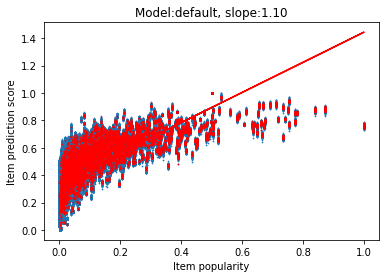

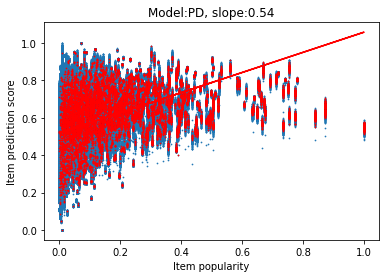

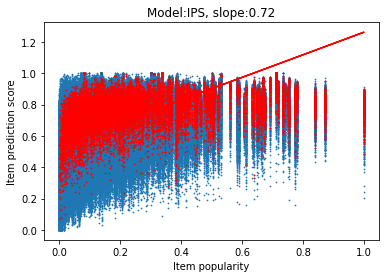

In [964]:
score_dataways = ['new_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['', 'PD', 'IPS']
seeds = [0]
x = global_popularity[item_idx[0].numpy()].to_numpy()
x = torch.tensor(np.tile(x,(1208,1)))
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, str(seed_tmp), '.pt']))
            y = ((predictions - predictions.min(axis=1).values.reshape(-1,1))/(predictions.max(axis=1).values - predictions.min(axis=1).values).reshape(-1,1))
            interacted_y = y[ui_pairs[:,0], ui_pairs[:,1]]
            interacted_x = x[ui_pairs[:,0], ui_pairs[:,1]]
            x_, y = x.reshape(-1), y.reshape(-1)
            m, b = np.polyfit(x_, y, 1)
            
            if model=='':
                model= 'default'
            plt.plot(x_, m*x_ + b, color='red')

            plt.scatter(x_, y, s=0.5)
            plt.scatter(interacted_x, interacted_y, color='red',s=0.5)
            plt.xlabel("Item popularity")
            plt.ylabel("Item prediction score")
            plt.title('Model:{}, slope:{:.2f}'.format(model, m))
            plt.show()

In [988]:
x.shape, y.shape, predictions.shape

((100,), torch.Size([3704]), torch.Size([1208, 3704]))

In [987]:
global_popularity.shape

(3704,)

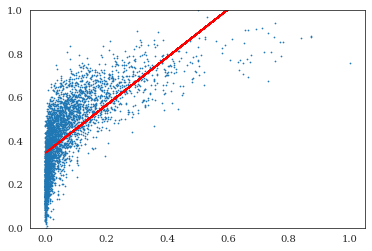

In [707]:
test_ways = ['new_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['']#, 'PD', 'IPS', 'ColA']
seeds = [0]
item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way, str(seed_tmp), '.pt']))
x = global_popularity[item_idx[0].numpy()].to_numpy()
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, str(seed_tmp), '.pt']))
            y = predictions.mean(axis=0)
            y = (y-y.min())/(y.max()-y.min())
            m, b = np.polyfit(x, y, 1)
            
            if model=='':
                model= 'default'
            #plt.plot(x, m*x + b, color='red')

            plt.scatter(x, y, s=0.5)
            plt.ylim(0,1)
            #lt.xlabel("Item popularity")
            #lt.ylabel("Item prediction score")
            #plt.title('Model:{}, slope:{:.2f}'.format(model, m))
            plt.savefig('./fig1.svg', format='svg')
            plt.show()
            
            

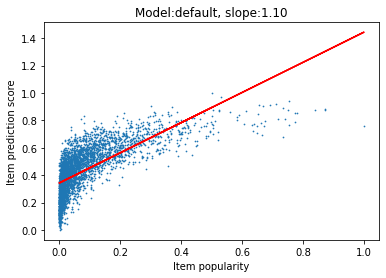

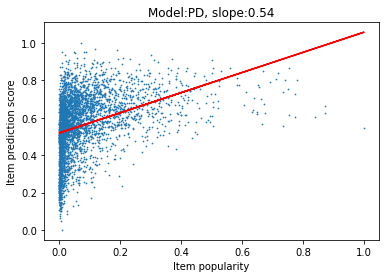

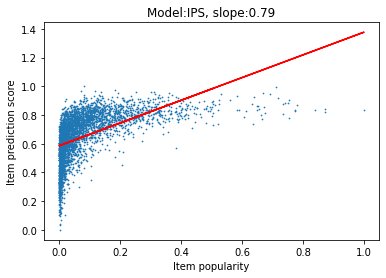

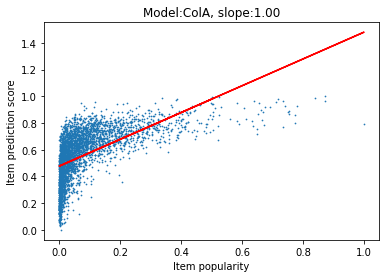

In [989]:
test_ways = ['new_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['', 'PD', 'IPS', 'ColA']
seeds = [0]
item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way+'PD', str(seed_tmp), '.pt']))
x = global_popularity[item_idx[0].numpy()].to_numpy()
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, str(seed_tmp), '.pt']))
            y = predictions.mean(axis=0)
            y = (y-y.min())/(y.max()-y.min())
            m, b = np.polyfit(x, y, 1)
            
            if model=='':
                model= 'default'
            plt.plot(x, m*x + b, color='red')

            plt.scatter(x, y, s=0.5)
            plt.xlabel("Item popularity")
            plt.ylabel("Item prediction score")
            plt.title('Model:{}, slope:{:.2f}'.format(model, m))
            plt.show()

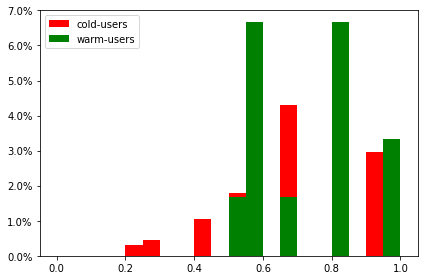

In [ ]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()< 50).any(axis=1).values], color='red' , bins=20, density=True, range=(0,1), label='cold-users')
ax.hist((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()][(warm_u_score_test.groupby(['user_id']).count()> 1000).any(axis=1).values], color='green', bins=20, density=True, range=(0,1), label='warm-users')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc='upper left')

In [795]:
(user_pop_cnt.sum()/user_pop_cnt.count())[np.sort(cold_u_score.user_id.unique())]

user_id
4       1.0
7       1.0
12      0.6
14      0.9
16      0.6
       ... 
6017    0.6
6027    0.9
6029    0.8
6034    0.8
6038    0.9
Name: pop, Length: 1208, dtype: float64

In [797]:
ui_pairs

array([[   0,  593],
       [   0, 2858],
       [   0, 3534],
       ...,
       [1207, 2414],
       [1207, 1680],
       [1207,  926]])

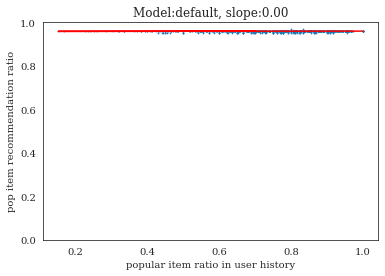

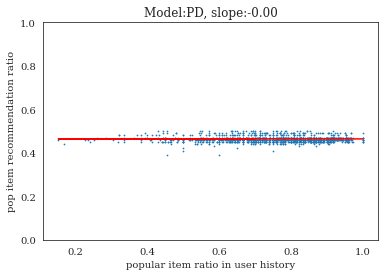

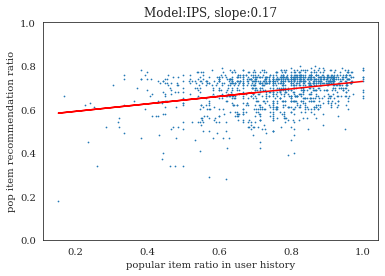

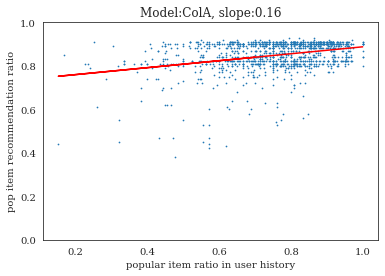

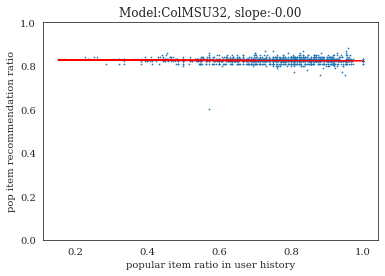

In [593]:
test_ways = ['new_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['', 'PD', 'IPS', 'ColA', 'ColMSU32']
seeds = [0]
masking=False
x = global_popularity[item_idx[0].numpy()].to_numpy()
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, str(seed_tmp), '.pt']))
            item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way+model, str(seed_tmp), '.pt']))
            evaluations = dict()
            #break
            # 이용기록을 masking을 하는 경우, 해당 인덱스를 -inf값으로 집어넣어준다. 값이 낮아야 -1을 곱한 후 오름차순 소팅하면 랭킹이 뒤로밀림. 
            if masking:
                sups = torch.load('_'.join(['../../eval_result/', 'total_sup', test_way, str(seed_tmp), '.pt']))
                ui_pairs = []
                for u_idx, u_sup in enumerate(sups):
                    for sup in u_sup:
                        ui_pairs.append([u_idx, sup])
                
                ui_pairs = np.array(ui_pairs)
                ui_pairs = convert_item_to_index(ui_pairs, item_idx)
                predictions[ui_pairs.transpose()] = float('-inf')


            # [user, item] prediction 결과를 sorting하고
            # sorting된 결과에서 pop_item의 비율을 재서 plot을 해봄.
            #topk = [10, 20, 50, 100, 500]
            #topk = [int(0.25*len(pop_items)), int(0.5*len(pop_items)), len(pop_items)]
            topk = [100]

            sort_idx = (-predictions).argsort(axis=1)
            item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
            for k in topk:
                pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
                
                x = (user_pop_cnt.sum()/user_pop_cnt.count())[np.sort(cold_u_score.user_id.unique())]
                y = pop_ratio
                m, b = np.polyfit(x, y, 1)

                if model=='':
                    model= 'default'
                plt.plot(x, m*x + b, color='red')

                plt.scatter(x, y, s=0.5)
                plt.xlabel("popular item ratio in user history")
                plt.ylabel("pop item recommendation ratio")
                plt.ylim(0,1)
                plt.title('Model:{}, slope:{:.2f}'.format(model, m))
                plt.show()

            break
        break

array([ 681, 2191, 2835, ..., 1844, 5314, 5525])

In [404]:
ui_pairs#[0][1]

array([[   0, 1210],
       [   0, 1097],
       [   0,  480],
       ...,
       [1207, 1148],
       [1207, 1276],
       [1207, 2716]])

In [408]:
ui_pairs

array([[   0, 1210],
       [   0, 1097],
       [   0,  480],
       ...,
       [1207, 1148],
       [1207, 1276],
       [1207, 2716]])

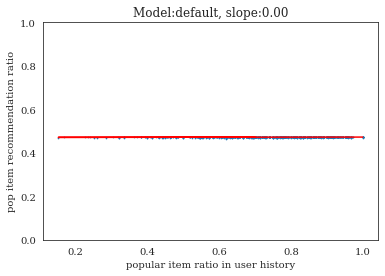

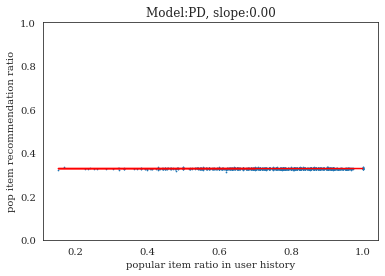

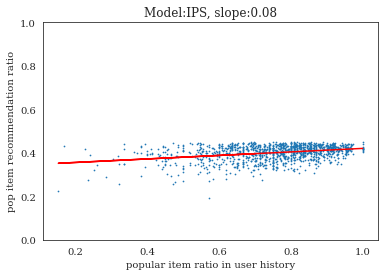

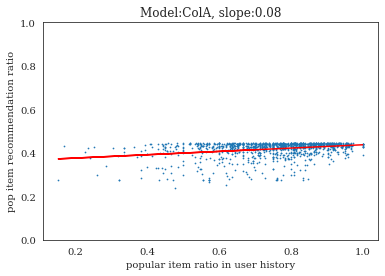

In [420]:
test_ways = ['new_user']
anchor_list=[total_items, pop_items, tail_items, niche_items]
models = ['', 'PD', 'IPS', 'ColA']
seeds = [0]
masking=False
x = global_popularity[item_idx[0].numpy()].to_numpy()
for model in models:
    for seed_tmp in seeds:
        for test_way in test_ways:
            predictions = torch.load('_'.join(['../../eval_result/', 'total_preds', test_way+model, str(seed_tmp), '.pt']))
            item_idx = torch.load('_'.join(['../../eval_result/', 'total_item_idx', test_way+model, str(seed_tmp), '.pt']))
            evaluations = dict()
            #break
            # 이용기록을 masking을 하는 경우, 해당 인덱스를 -inf값으로 집어넣어준다. 값이 낮아야 -1을 곱한 후 오름차순 소팅하면 랭킹이 뒤로밀림. 
            if masking:
                sups = torch.load('_'.join(['../../eval_result/', 'total_sup', test_way, str(seed_tmp), '.pt']))
                ui_pairs = []
                for u_idx, u_sup in enumerate(sups):
                    for sup in u_sup:
                        ui_pairs.append([u_idx, sup])
                
                ui_pairs = np.array(ui_pairs)
                ui_pairs = convert_item_to_index(ui_pairs, item_idx)
                predictions[ui_pairs.transpose()] = float('-inf')


            # [user, item] prediction 결과를 sorting하고
            # sorting된 결과에서 pop_item의 비율을 재서 plot을 해봄.
            #topk = [10, 20, 50, 100, 500]
            #topk = [int(0.25*len(pop_items)), int(0.5*len(pop_items)), len(pop_items)]
            topk = [int(1*len(pop_items))*2]

            sort_idx = (-predictions).argsort(axis=1)
            item_rank = np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1) # rank items in descending order
            for k in topk:
                pop_ratio = np.isin(item_rank[..., :k], pop_items).mean(axis=-1)#.mean() # check percentage of popular items in top-k predictions
                
                x = (user_pop_cnt.sum()/user_pop_cnt.count())[np.sort(cold_u_score.user_id.unique())]
                y = pop_ratio
                m, b = np.polyfit(x, y, 1)

                if model=='':
                    model= 'default'
                plt.plot(x, m*x + b, color='red')

                plt.scatter(x, y, s=0.5)
                plt.xlabel("popular item ratio in user history")
                plt.ylabel("pop item recommendation ratio")
                plt.ylim(0,1)
                plt.title('Model:{}, slope:{:.2f}'.format(model, m))
                plt.show()

            break
        break

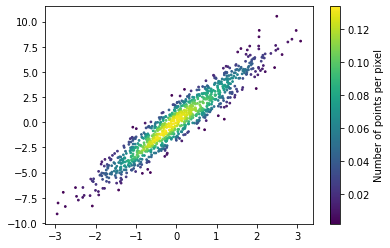

In [533]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = np.random.normal(size=1000)
y = x * 3 + np.random.normal(size=1000)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
density = ax.scatter(x, y, c=z, s=3)
fig.colorbar(density, label='Number of points per pixel')
plt.show()

distribution of prediction: normalized prediction scores of top 100 users and bottom 100 users

model prediction 결과를 소팅해서
1. prediction 결과를 유저별로 보는
2. 

model이 adapt 되기 전에 model prediction 결과를 한 번 봐야함. adapt 된 이후에는 값이 달라질 수 있으니.
업데이트하면 어떻게 달라지는지도 보자.

어느 유저들이 추천이 잘 안되는가

어느 유저들이 잘 커버가 안되는가